In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import gc
import os
import sys
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics, preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans

from tqdm import tqdm

sns.set_style('darkgrid')

pd.options.display.float_format = '{:,.3f}'.format

print('Files in input folder:', os.listdir("../input"))

Files in input folder: ['ieee-fraud-detection']


In [3]:
def reduceMemUsage(df):
    startMem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        colType = df[col].dtype
    
        if colType != object:
            c_min = df[col].min()
            c_max = df[col].max()
    
            if pd.api.types.is_integer_dtype(colType):
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    endMem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage reduced: {startMem:.2f} MB → {endMem:.2f} MB '
          f'({100 * (startMem - endMem) / startMem:.1f}% reduction)')
    
    return df

In [4]:
train_id = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
train_trn = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')

In [5]:
train_id = reduceMemUsage(train_id)
train_trn = reduceMemUsage(train_trn)

Memory usage reduced: 45.12 MB → 25.86 MB (42.7% reduction)
Memory usage reduced: 1775.15 MB → 542.35 MB (69.4% reduction)


In [6]:
print(train_id.shape, train_trn.shape)

(144233, 41) (590540, 394)


# Data Analysis

isFraud,0,1
proportion,0.965,0.035


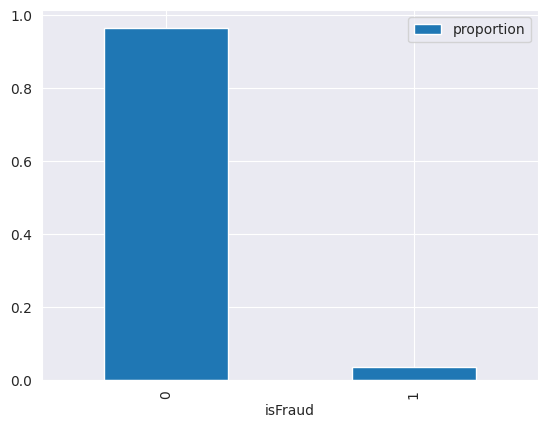

In [7]:
fc = train_trn['isFraud'].value_counts(normalize = True).to_frame()
fc.plot.bar()
fc.T

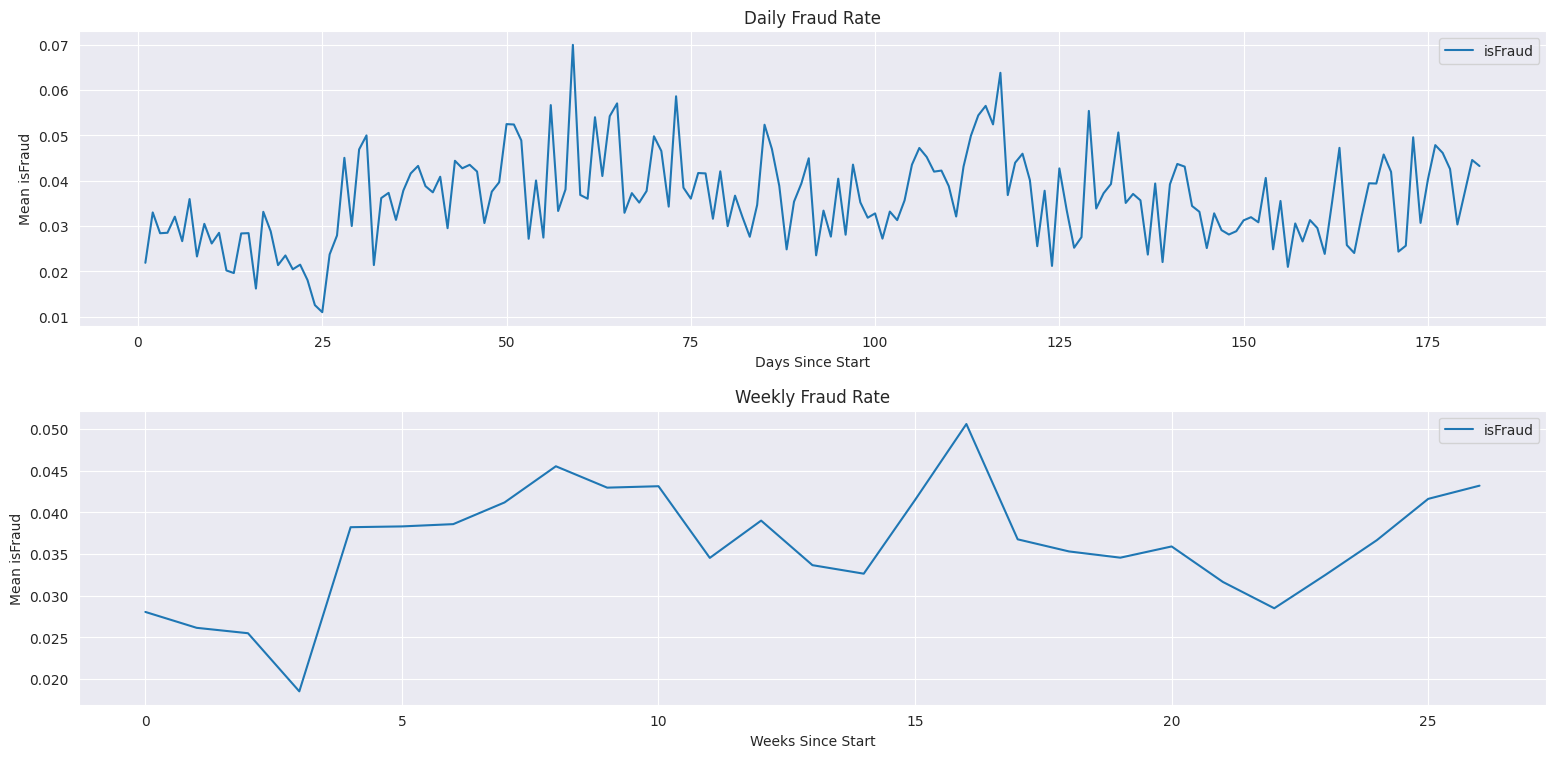

In [8]:
fig, ax = plt.subplots(2, 1, figsize = (16,8))

train_trn['_seq_day'] = train_trn['TransactionDT'] // (24*60*60)
train_trn['_seq_week'] = train_trn['_seq_day'] // 7

train_trn.groupby('_seq_day')['isFraud'].mean().to_frame().plot.line(ax = ax[0])
train_trn.groupby('_seq_week')['isFraud'].mean().to_frame().plot.line(ax = ax[1])

plt.tight_layout(pad = 3.0)
ax[0].set_title('Daily Fraud Rate')
ax[0].set_xlabel('Days Since Start')
ax[0].set_ylabel('Mean isFraud')

ax[1].set_title('Weekly Fraud Rate')
ax[1].set_xlabel('Weeks Since Start')
ax[1].set_ylabel('Mean isFraud')

ax[0].grid(True)
ax[1].grid(True)

sns.set(style='whitegrid')

In [9]:
import datetime
startDate = datetime.datetime.strptime('2024-09-08', "%Y-%m-%d")
lastDate = startDate + datetime.timedelta(seconds = train_trn['TransactionDT'].max())

In [10]:
print(lastDate)

2025-03-09 23:58:51


In [11]:
train_trn.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V332,V333,V334,V335,V336,V337,V338,V339,_seq_day,_seq_week
0,2987000,0,86400,68.500,W,13926,NaN,150.000,discover,142.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
1,2987001,0,86401,29.000,W,2755,404.000,150.000,mastercard,102.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2,2987002,0,86469,59.000,W,4663,490.000,150.000,visa,166.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
3,2987003,0,86499,50.000,W,18132,567.000,150.000,mastercard,117.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
4,2987004,0,86506,50.000,H,4497,514.000,150.000,mastercard,102.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,0


In [12]:
train_trn['_Date'] = train_trn['TransactionDT'].apply(lambda x: (startDate + datetime.timedelta(seconds = x)))

In [13]:
train_trn.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V333,V334,V335,V336,V337,V338,V339,_seq_day,_seq_week,_Date
0,2987000,0,86400,68.500,W,13926,NaN,150.000,discover,142.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,2024-09-09 00:00:00
1,2987001,0,86401,29.000,W,2755,404.000,150.000,mastercard,102.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,2024-09-09 00:00:01
2,2987002,0,86469,59.000,W,4663,490.000,150.000,visa,166.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,2024-09-09 00:01:09
3,2987003,0,86499,50.000,W,18132,567.000,150.000,mastercard,117.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,2024-09-09 00:01:39
4,2987004,0,86506,50.000,H,4497,514.000,150.000,mastercard,102.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,0,2024-09-09 00:01:46


In [14]:
train_trn['_ymd'] = train_trn['_Date'].dt.year.astype(str) + '-' + train_trn['_Date'].dt.month.astype(str) + '-' + train_trn['_Date'].dt.day.astype(str)
train_trn['_year_month'] = train_trn['_Date'].dt.year.astype(str) + '-' + train_trn['_Date'].dt.month.astype(str)
train_trn['_weekday'] = train_trn['_Date'].dt.dayofweek
train_trn['_hour'] = train_trn['_Date'].dt.hour
train_trn['_day'] = train_trn['_Date'].dt.day

In [15]:
train_trn.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V338,V339,_seq_day,_seq_week,_Date,_ymd,_year_month,_weekday,_hour,_day
0,2987000,0,86400,68.500,W,13926,NaN,150.000,discover,142.000,...,NaN,NaN,1,0,2024-09-09 00:00:00,2024-9-9,2024-9,0,0,9
1,2987001,0,86401,29.000,W,2755,404.000,150.000,mastercard,102.000,...,NaN,NaN,1,0,2024-09-09 00:00:01,2024-9-9,2024-9,0,0,9
2,2987002,0,86469,59.000,W,4663,490.000,150.000,visa,166.000,...,NaN,NaN,1,0,2024-09-09 00:01:09,2024-9-9,2024-9,0,0,9
3,2987003,0,86499,50.000,W,18132,567.000,150.000,mastercard,117.000,...,NaN,NaN,1,0,2024-09-09 00:01:39,2024-9-9,2024-9,0,0,9
4,2987004,0,86506,50.000,H,4497,514.000,150.000,mastercard,102.000,...,0.000,0.000,1,0,2024-09-09 00:01:46,2024-9-9,2024-9,0,0,9


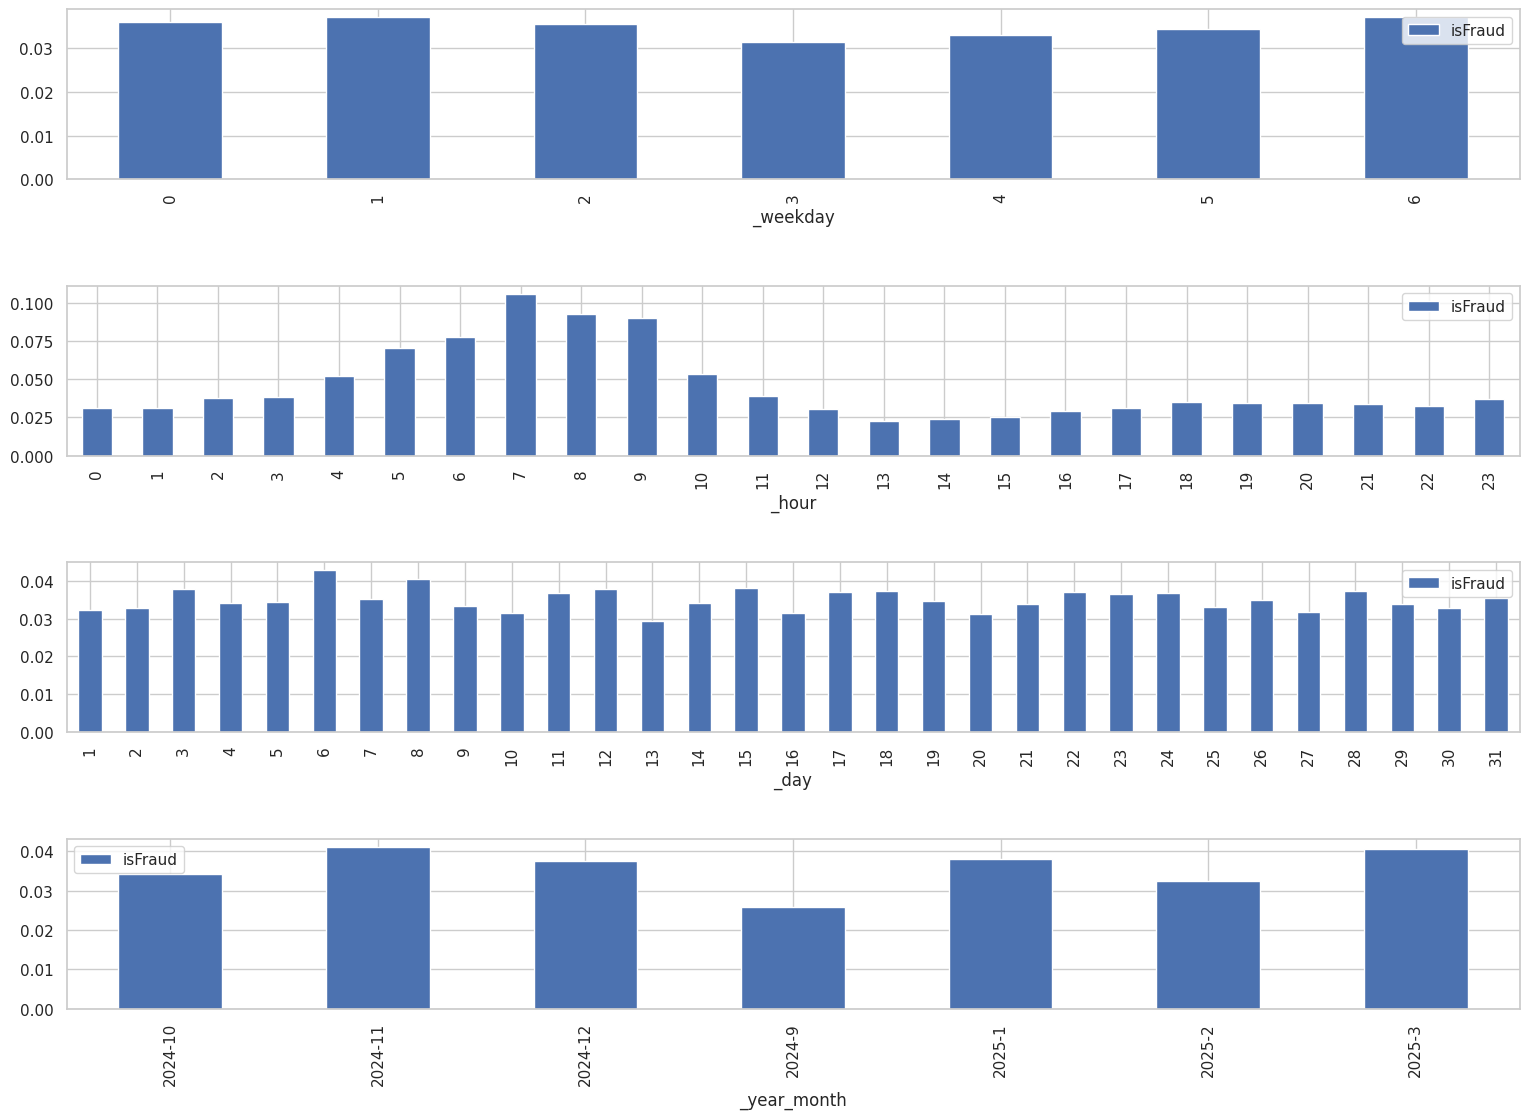

In [16]:
fig,ax = plt.subplots(4, 1, figsize=(16,12))

train_trn.groupby('_weekday')['isFraud'].mean().to_frame().plot.bar(ax=ax[0])
train_trn.groupby('_hour')['isFraud'].mean().to_frame().plot.bar(ax=ax[1])
train_trn.groupby('_day')['isFraud'].mean().to_frame().plot.bar(ax=ax[2])
train_trn.groupby('_year_month')['isFraud'].mean().to_frame().plot.bar(ax=ax[3])

plt.tight_layout(pad = 3.0)

**Fraud Transaction Rate By Day**

In [17]:
df = train_trn.groupby(['_ymd'])['isFraud'].agg(['count','mean','sum'])
df.sort_values(by='mean',ascending=False)[:10].T

_ymd,2024-11-6,2025-1-3,2024-11-20,2024-11-12,2024-11-3,2025-1-1,2025-1-15,2024-12-31,2024-11-11,2024-11-9
count,"2,402.000","3,042.000","2,304.000","3,209.000","2,789.000","2,461.000","2,348.000","2,758.000","4,317.000","3,057.000"
mean,0.070,0.064,0.059,0.057,0.057,0.056,0.055,0.054,0.054,0.054
sum,168.000,194.000,135.000,183.000,158.000,139.000,130.000,150.000,234.000,165.000


In [18]:
df.sort_values(by='count',ascending=False)[:10].T

_ymd,2024-9-30,2024-12-9,2024-10-2,2024-10-1,2024-9-28,2024-10-3,2024-9-29,2024-9-26,2024-9-27,2024-9-9
count,"6,852.000","6,252.000","6,065.000","5,872.000","5,749.000","5,742.000","5,677.000","5,585.000","5,526.000","5,122.000"
mean,0.021,0.024,0.013,0.018,0.023,0.011,0.020,0.029,0.021,0.022
sum,147.000,147.000,76.000,106.000,135.000,63.000,116.000,161.000,118.000,112.000


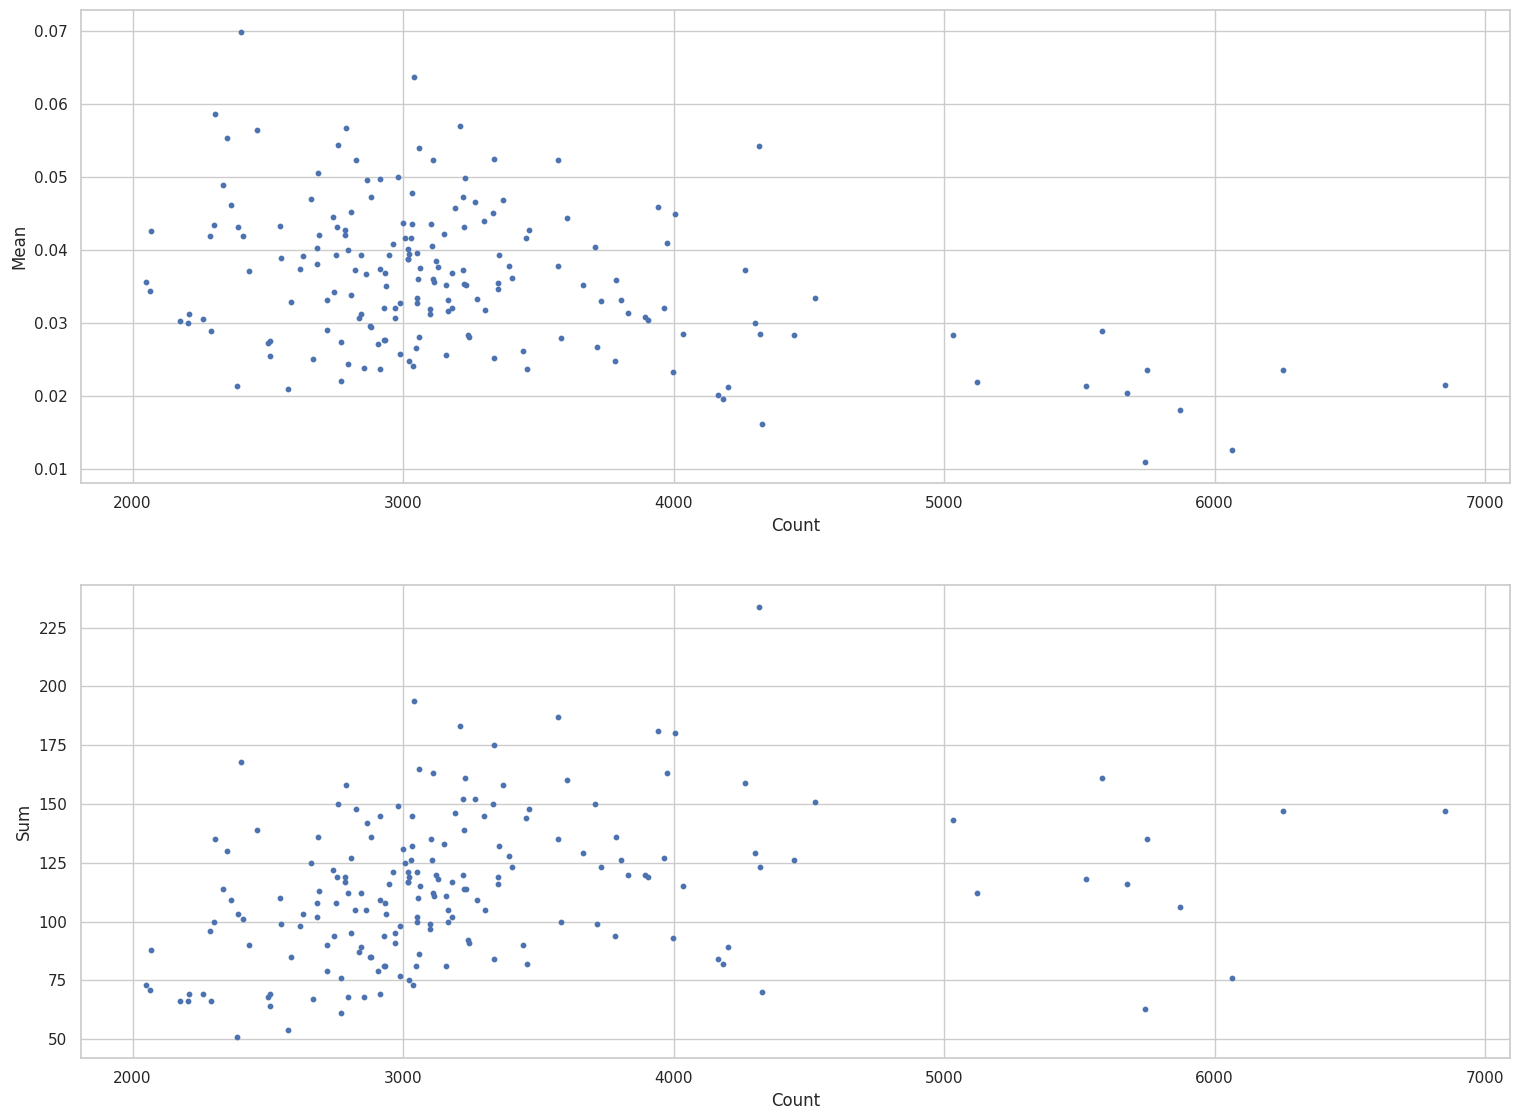

In [19]:
fig, ax = plt.subplots(2, 1, figsize = (16,12))
ax[0].scatter(df['count'], df['mean'], s=10)
ax[1].scatter(df['count'], df['sum'], s=10)

ax[0].set_xlabel('Count')
ax[0].set_ylabel('Mean')

ax[1].set_xlabel('Count')
ax[1].set_ylabel('Sum')

plt.tight_layout(pad = 3.0)

**Fraud Transaction Rate by Weekday-Hour**

<Axes: xlabel='_weekday_hour'>

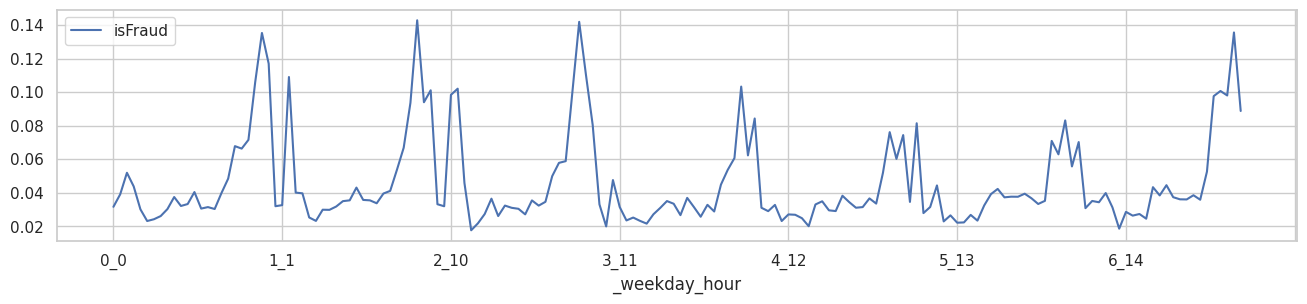

In [20]:
train_trn['_weekday_hour'] = train_trn['_weekday'].astype(str) + '_' + train_trn['_hour'].astype(str)
train_trn.groupby('_weekday_hour')['isFraud'].mean().to_frame().plot.line(figsize=(16,3))

**Fraud Transaction Rate by Weekday**

In [21]:
df = train_trn.groupby('_weekday')['isFraud'].mean().to_frame()
df.sort_values(by='isFraud', ascending=False)

,isFraud
_weekday,
6,0.037
1,0.037
0,0.036
2,0.036
5,0.035
4,0.033
3,0.031


**Fraud Transaction Rate by Hour**

In [22]:
df = train_trn.groupby('_hour')['isFraud'].mean().to_frame()
df.sort_values(by='isFraud', ascending=False).head(10)

,isFraud
_hour,
7,0.106
8,0.093
9,0.090
6,0.078
5,0.070
10,0.053
4,0.052
11,0.039
3,0.038


**Fraud Transaction Rate by Weekday-Hour**

In [23]:
df = train_trn.groupby('_weekday_hour')['isFraud'].mean().to_frame()
df.sort_values(by='isFraud', ascending=False).head(10)

,isFraud
_weekday_hour,
1_7,0.143
2_7,0.142
6_8,0.136
0_8,0.135
0_9,0.117
2_8,0.110
1_10,0.109
0_7,0.106
3_7,0.103


**Fraud Transaction Rate by Amount-bin**

In [24]:
train_trn['TransactionAmt'] = train_trn['TransactionAmt'].astype('float32')
train_trn['_amount_qcut10'] = pd.qcut(train_trn['TransactionAmt'],10)
df = train_trn.groupby('_amount_qcut10')['isFraud'].mean().to_frame()
df.sort_values(by='isFraud', ascending=False)

,isFraud
_amount_qcut10,
"(0.25, 25.953]",0.056
"(275.25, 31936.0]",0.051
"(117.0, 160.0]",0.043
"(160.0, 275.25]",0.038
"(68.75, 100.0]",0.036
"(35.938, 49.0]",0.032
"(25.953, 35.938]",0.032
"(57.938, 68.75]",0.029
"(100.0, 117.0]",0.020


# Transaction ID

In [25]:
fraud_id = train_trn[train_trn['isFraud'] == 1]['TransactionID']
fraud_id_in_trn = [i for i in fraud_id if i in train_id['TransactionID'].values]
print(f'fraud data count : {len(fraud_id)}, and in trn: {len(fraud_id_in_trn)}')

fraud data count : 20663, and in trn: 11318


In [26]:
train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.000,"70,787.000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.000,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.000,"98,945.000",NaN,NaN,0.000,-5.000,NaN,NaN,NaN,...,mobile safari 11.0,32.000,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.000,"191,631.000",0.000,0.000,0.000,0.000,NaN,NaN,0.000,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.000,"221,832.000",NaN,NaN,0.000,-6.000,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.000,"7,460.000",0.000,0.000,1.000,0.000,NaN,NaN,0.000,...,chrome 62.0,24.000,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [27]:
train_id.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

In [28]:
train_id['id_30'].head()

0         Android 7.0
1          iOS 11.1.2
2                 NaN
3                 NaN
4    Mac OS X 10_11_6
Name: id_30, dtype: object

**Important Columns from Train ID**
* id_30
* id_31
* Device Type
* Device Info

In [29]:
id_cols = [col for col in train_id.columns if col.startswith('id_')]

train_id[id_cols].head().T

,0,1,2,3,4
id_01,0.000,-5.000,-5.000,-5.000,0.000
id_02,"70,787.000","98,945.000","191,631.000","221,832.000","7,460.000"
id_03,NaN,NaN,0.000,NaN,0.000
id_04,NaN,NaN,0.000,NaN,0.000
id_05,NaN,0.000,0.000,0.000,1.000
id_06,NaN,-5.000,0.000,-6.000,0.000
id_07,NaN,NaN,NaN,NaN,NaN
id_08,NaN,NaN,NaN,NaN,NaN
id_09,NaN,NaN,0.000,NaN,0.000
id_10,NaN,NaN,0.000,NaN,0.000


# Merging Both the Trn and Id of Train

In [30]:
train_full = pd.merge(train_trn, train_id, on = 'TransactionID', how = 'inner')

In [31]:
train_full.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0,86506,50.000,H,4497,514.000,150.000,mastercard,102.000,...,samsung browser 6.2,32.000,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,0,86535,15.000,H,2803,100.000,150.000,visa,226.000,...,mobile safari 11.0,32.000,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,0,86549,75.875,C,16496,352.000,117.000,mastercard,134.000,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,0,86555,16.500,C,4461,375.000,185.000,mastercard,224.000,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0,86620,30.000,H,1790,555.000,150.000,visa,226.000,...,chrome 62.0,24.000,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [32]:
len(train_full)

144233

In [33]:
train_full_f0 = train_full[train_full['isFraud'] == 0]
train_full_f1 = train_full[train_full['isFraud'] == 1]

In [34]:
def plotHistByFraud(col, bins=20, figsize=(8,3)):
    with np.errstate(invalid='ignore'):
        plt.figure(figsize=figsize)
        plt.hist([train_full_f0[col], train_full_f1[col]], bins=bins, density=True, color=['royalblue', 'orange'])

In [35]:
def plotCategoryRateBar(col, topN=np.nan, figsize=(8,3)):
    a, b = train_full_f0, train_full_f1
    if topN == topN:
        vals = b[col].value_counts(normalize=True).to_frame().iloc[:topN,0]
        subA = a.loc[a[col].isin(vals.index.values), col]
        df = pd.DataFrame({'normal':subA.value_counts(normalize=True), 'fraud':vals})
    else:
        df = pd.DataFrame({'normal':a[col].value_counts(normalize=True), 'fraud':b[col].value_counts(normalize=True)})
    df.sort_values('fraud', ascending=False).plot.bar(figsize=figsize)

In [36]:
id_cols = [col for col in train_full.columns if col.startswith('id_')]
print(f'Total id columns: {len(id_cols)}')

Total id columns: 38


In [37]:
from pandas.api.types import is_numeric_dtype

def plot_all_ids(id_cols):
    for col in id_cols:
        print(f'Plotting: {col}')
        try:
            if is_numeric_dtype(train_full[col]):
                plotHistByFraud(col)
                plt.title(f'Histogram of {col} by Fraud')
                plt.show()
            else:
                plotCategoryRateBar(col, topN=10)
                plt.title(f'Category Rate of {col} by Fraud')
                plt.show()
        except Exception as e:
            print(f'Could not plot {col}: {e}')

Plotting: id_01


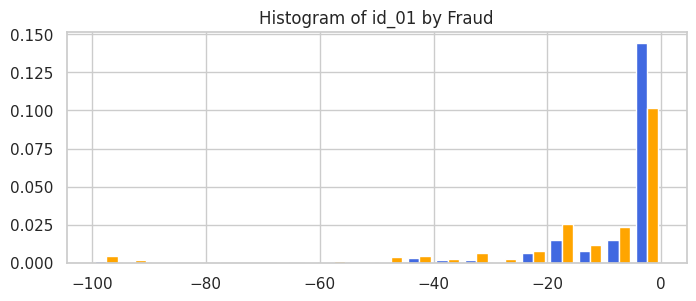

Plotting: id_02


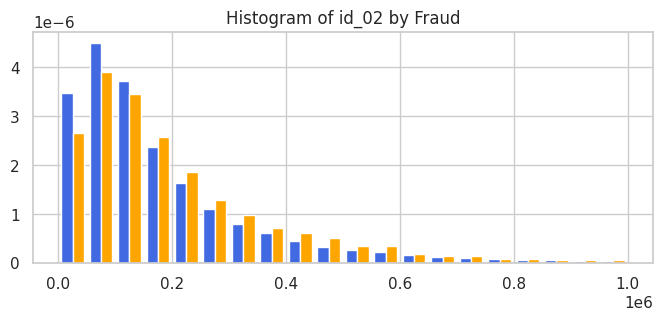

Plotting: id_03


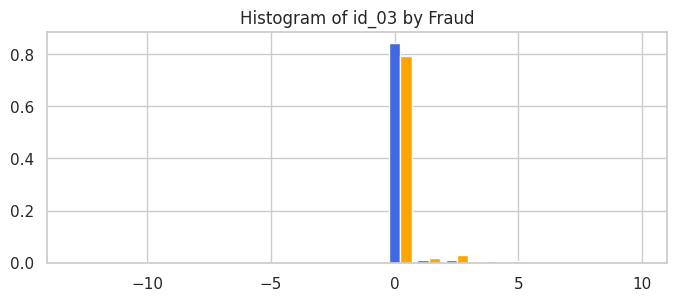

Plotting: id_04


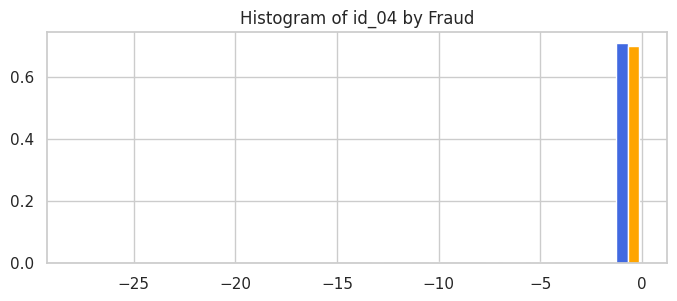

Plotting: id_05


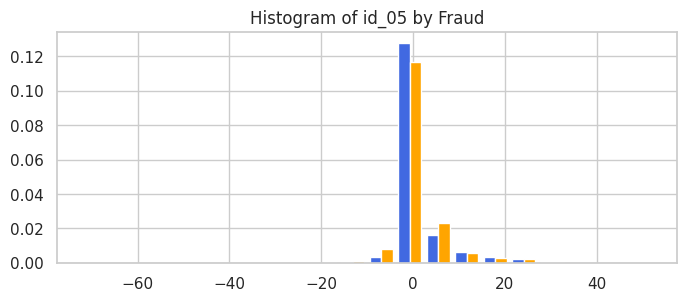

Plotting: id_06


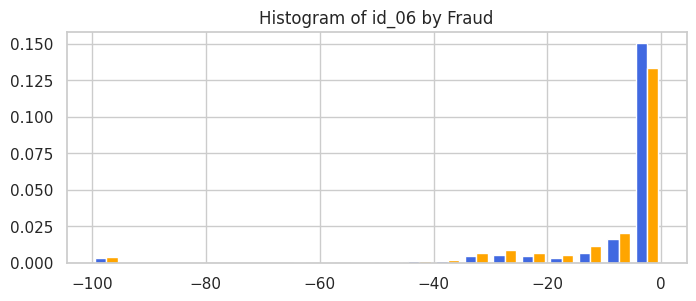

Plotting: id_07


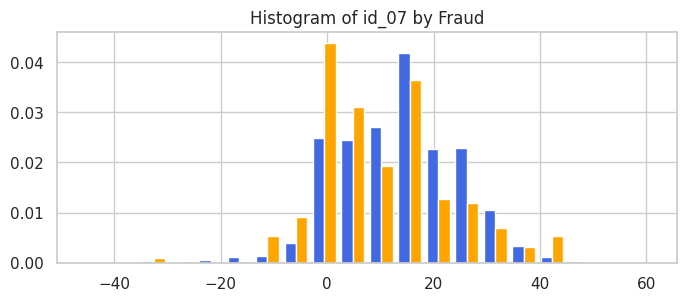

Plotting: id_08


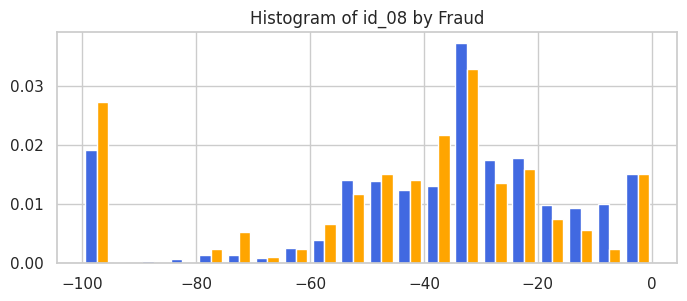

Plotting: id_09


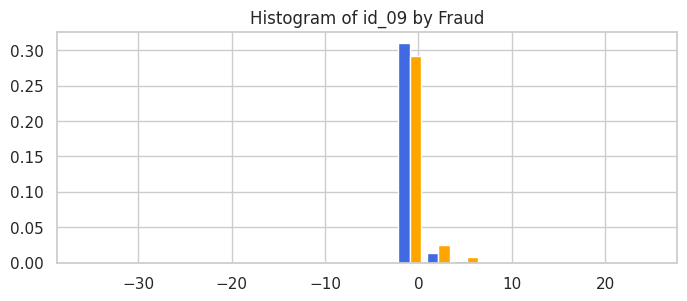

Plotting: id_10


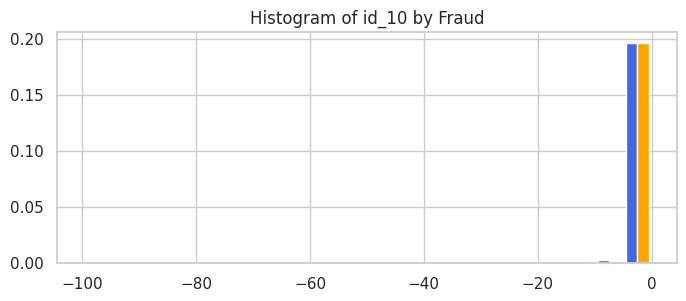

Plotting: id_11


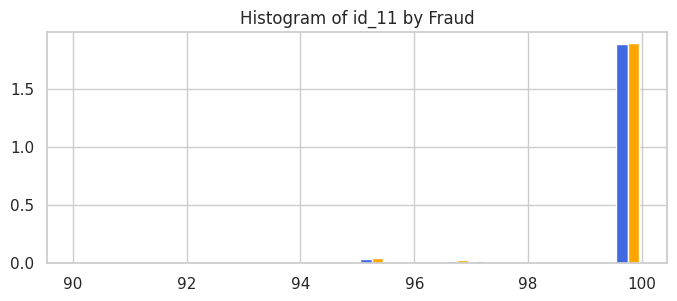

Plotting: id_12


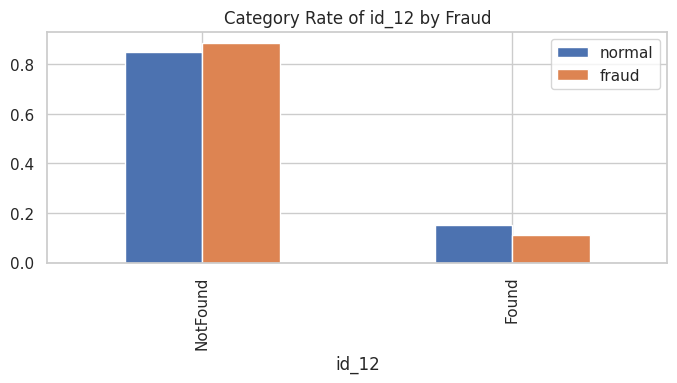

Plotting: id_13


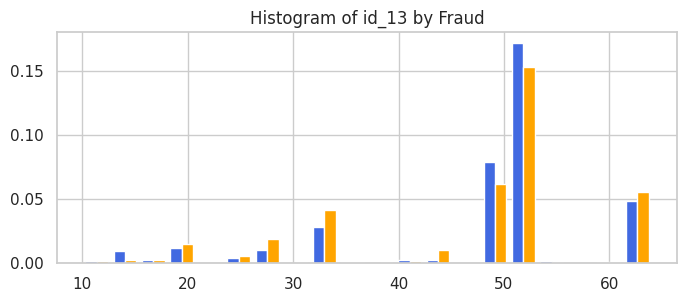

Plotting: id_14


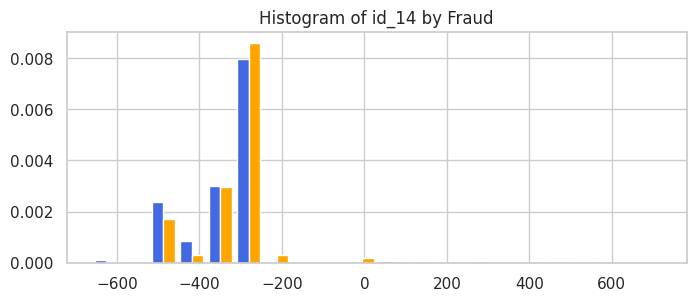

Plotting: id_15


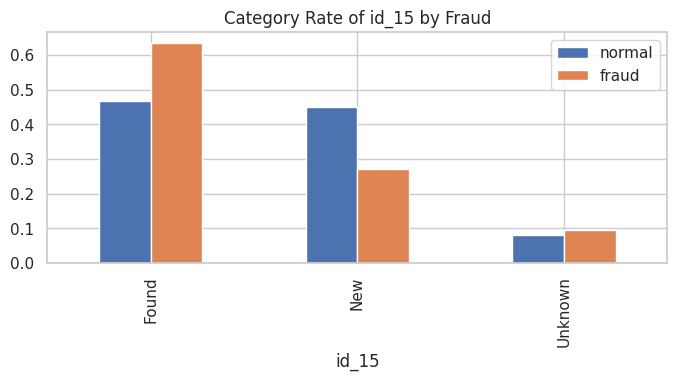

Plotting: id_16


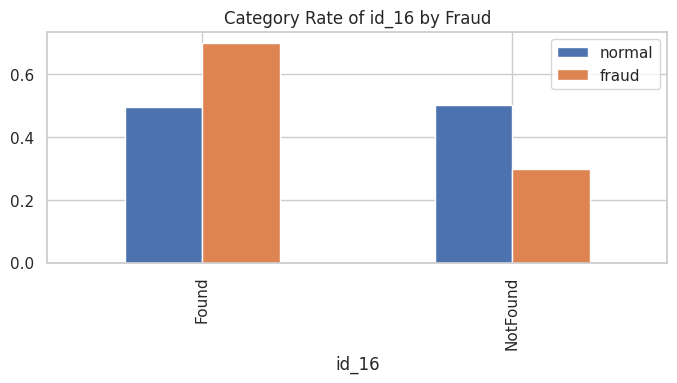

Plotting: id_17


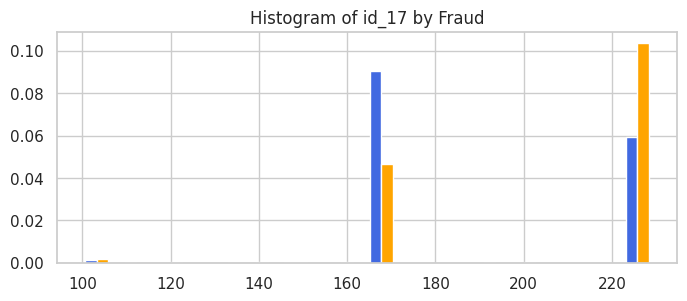

Plotting: id_18


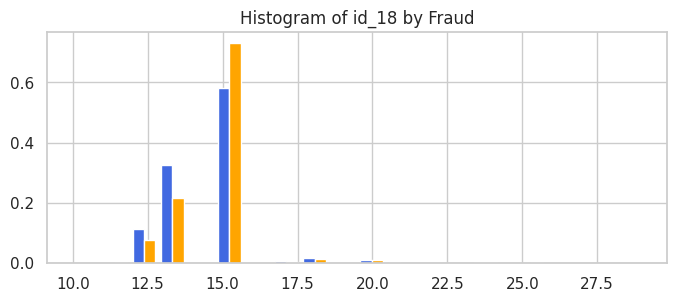

Plotting: id_19


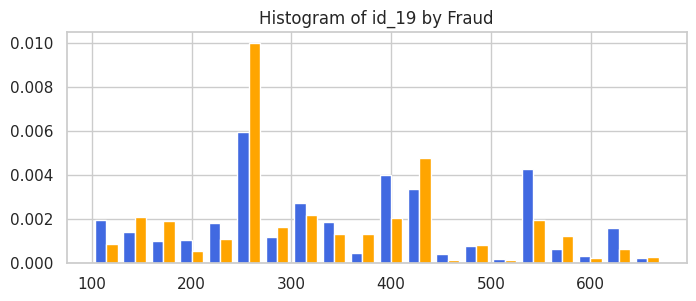

Plotting: id_20


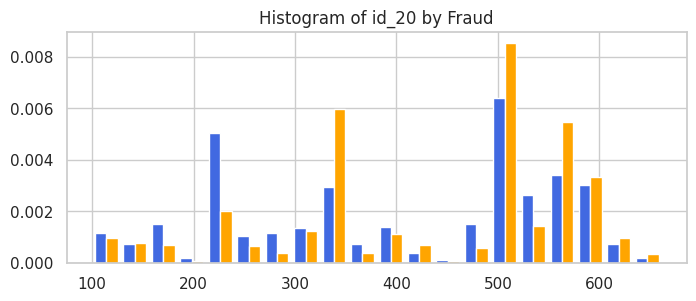

Plotting: id_21


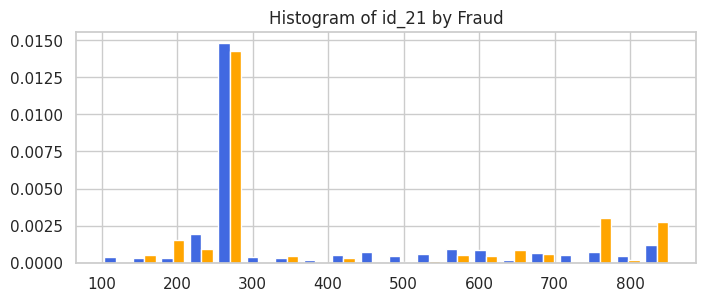

Plotting: id_22


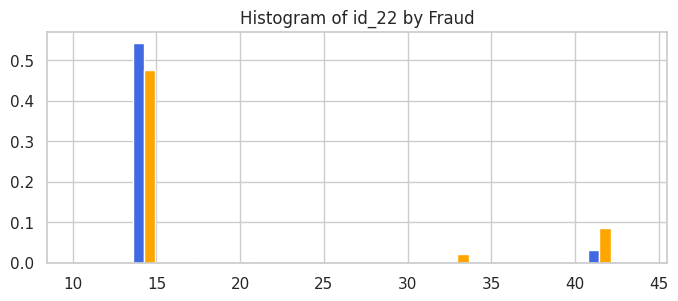

Plotting: id_23


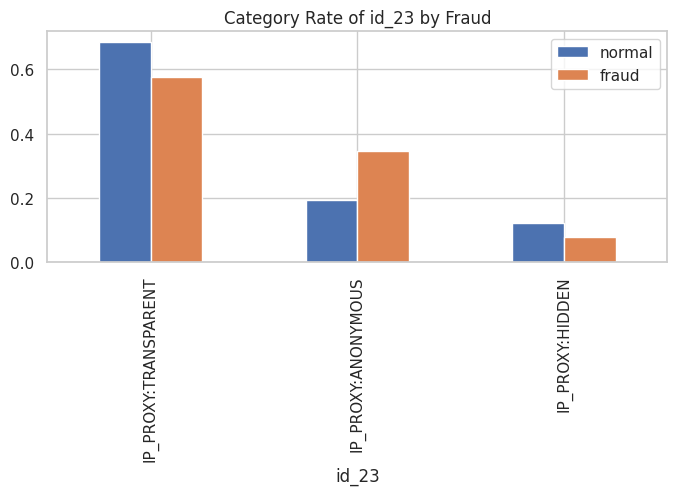

Plotting: id_24


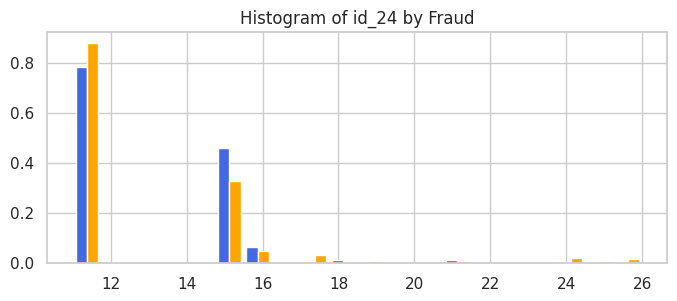

Plotting: id_25


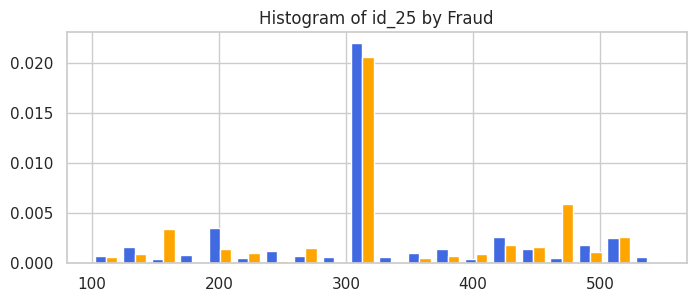

Plotting: id_26


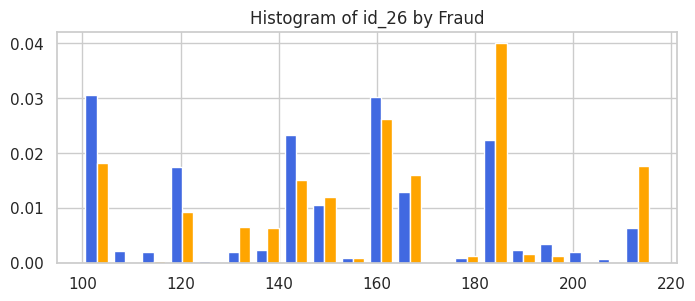

Plotting: id_27


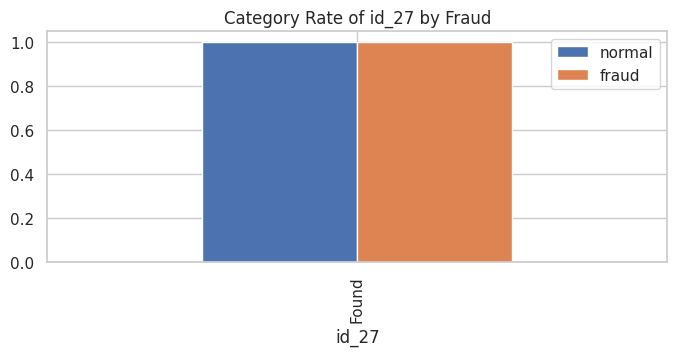

Plotting: id_28


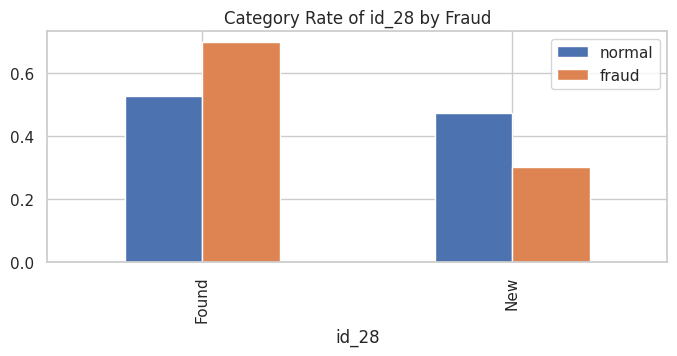

Plotting: id_29


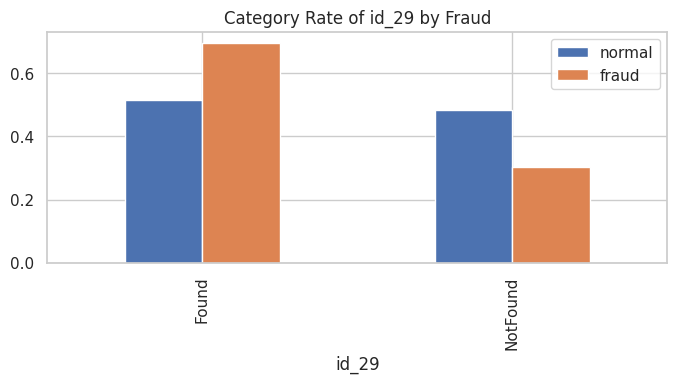

Plotting: id_30


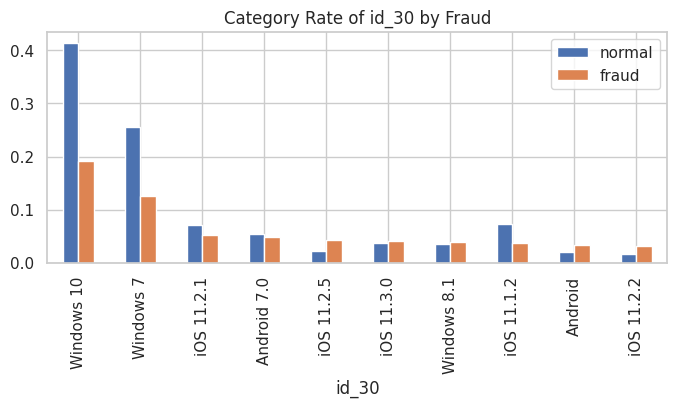

Plotting: id_31


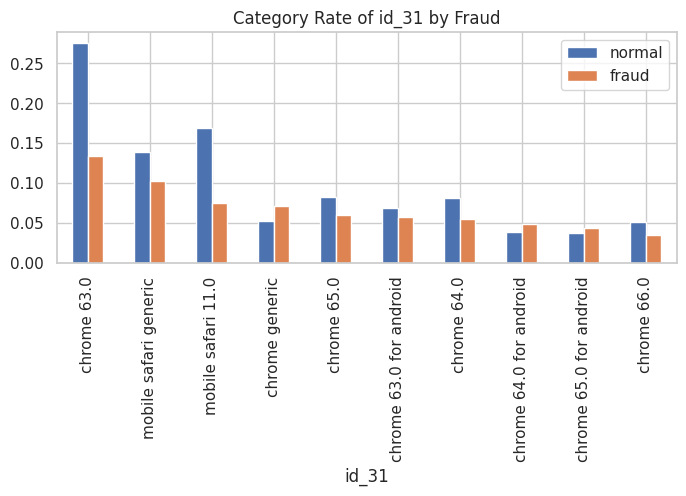

Plotting: id_32


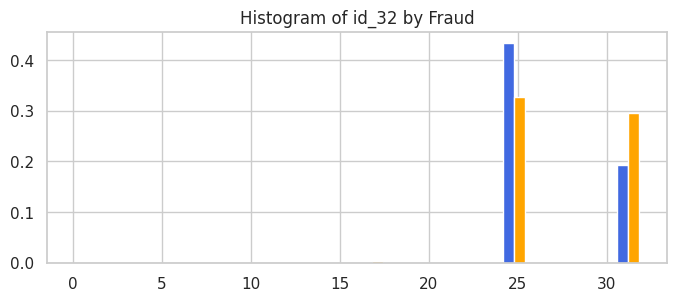

Plotting: id_33


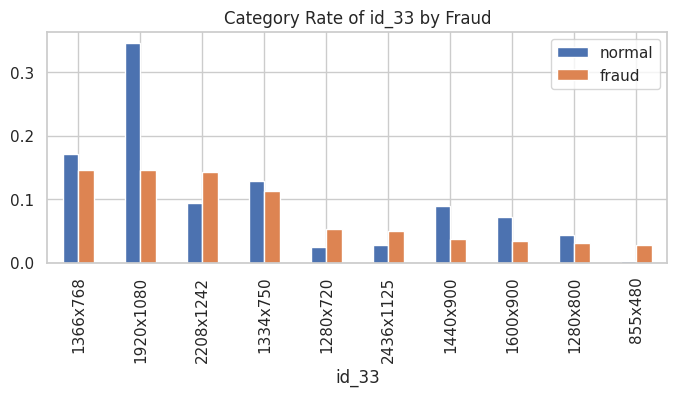

Plotting: id_34


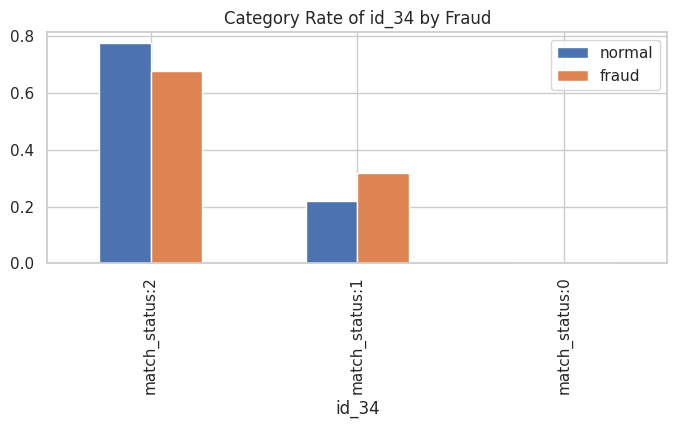

Plotting: id_35


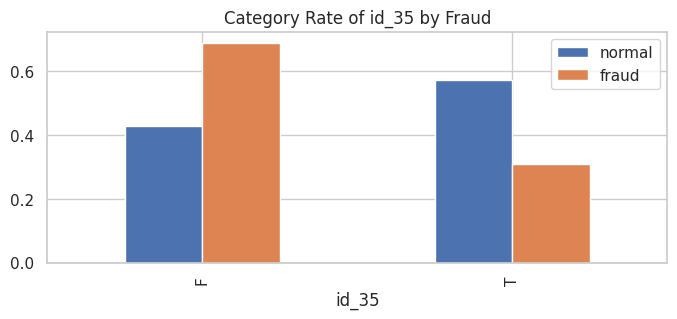

Plotting: id_36


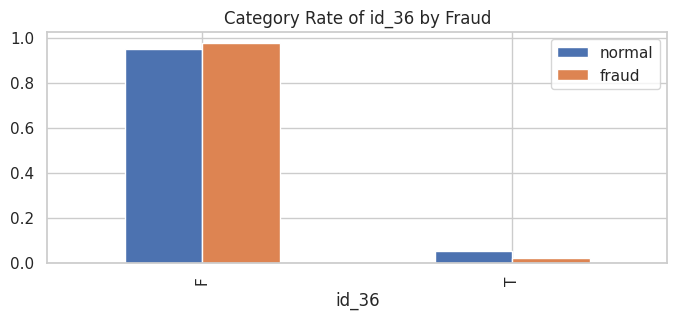

Plotting: id_37


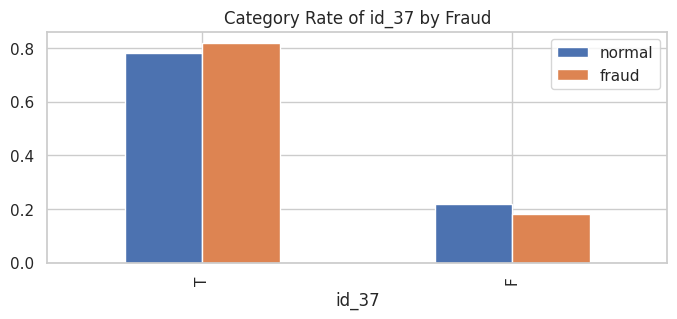

Plotting: id_38


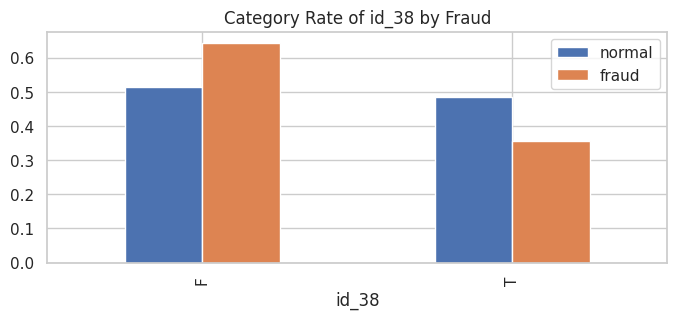

In [38]:
plot_all_ids(id_cols)

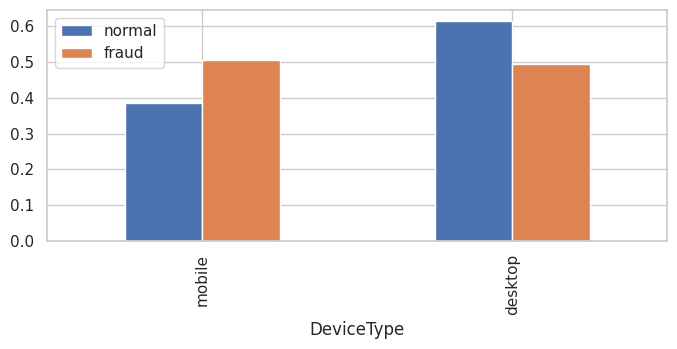

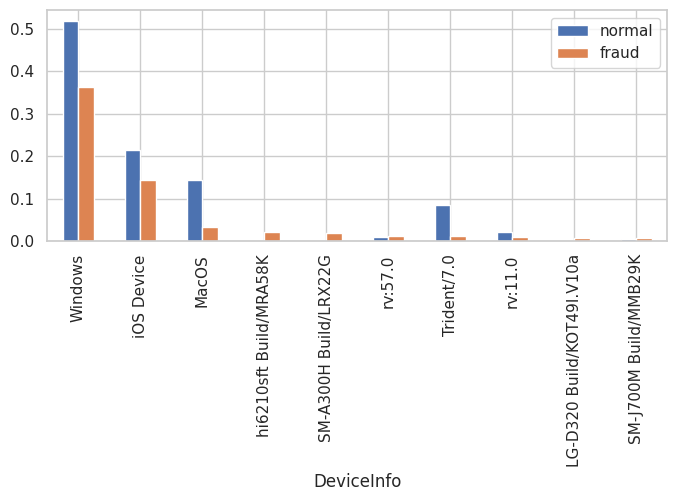

In [39]:
plotCategoryRateBar('DeviceType')
plotCategoryRateBar('DeviceInfo',10)

In [40]:
train_id.head().T

,0,1,2,3,4
TransactionID,2987004,2987008,2987010,2987011,2987016
id_01,0.000,-5.000,-5.000,-5.000,0.000
id_02,"70,787.000","98,945.000","191,631.000","221,832.000","7,460.000"
id_03,NaN,NaN,0.000,NaN,0.000
id_04,NaN,NaN,0.000,NaN,0.000
id_05,NaN,0.000,0.000,0.000,1.000
id_06,NaN,-5.000,0.000,-6.000,0.000
id_07,NaN,NaN,NaN,NaN,NaN
id_08,NaN,NaN,NaN,NaN,NaN
id_09,NaN,NaN,0.000,NaN,0.000


In [41]:
print(train_full.columns.tolist())

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V

In [42]:
v_columns = [col for col in train_trn.columns if col.startswith('V')]

for col in v_columns:
    print(f"\nColumn: {col}")
    print(train_trn[col].head(5))


Column: V1
0   1.000
1     NaN
2   1.000
3     NaN
4     NaN
Name: V1, dtype: float16

Column: V2
0   1.000
1     NaN
2   1.000
3     NaN
4     NaN
Name: V2, dtype: float16

Column: V3
0   1.000
1     NaN
2   1.000
3     NaN
4     NaN
Name: V3, dtype: float16

Column: V4
0   1.000
1     NaN
2   1.000
3     NaN
4     NaN
Name: V4, dtype: float16

Column: V5
0   1.000
1     NaN
2   1.000
3     NaN
4     NaN
Name: V5, dtype: float16

Column: V6
0   1.000
1     NaN
2   1.000
3     NaN
4     NaN
Name: V6, dtype: float16

Column: V7
0   1.000
1     NaN
2   1.000
3     NaN
4     NaN
Name: V7, dtype: float16

Column: V8
0   1.000
1     NaN
2   1.000
3     NaN
4     NaN
Name: V8, dtype: float16

Column: V9
0   1.000
1     NaN
2   1.000
3     NaN
4     NaN
Name: V9, dtype: float16

Column: V10
0   0.000
1     NaN
2   0.000
3     NaN
4     NaN
Name: V10, dtype: float16

Column: V11
0   0.000
1     NaN
2   0.000
3     NaN
4     NaN
Name: V11, dtype: float16

Column: V12
0   1.000
1   0.000
2   1.

In [43]:
v_cols = [col for col in train_full.columns if col.startswith('V')]
train_full = train_full.drop(columns=v_cols)

In [44]:
train_full.head().T

,0,1,2,3,4
TransactionID,2987004,2987008,2987010,2987011,2987016
isFraud,0,0,0,0,0
TransactionDT,86506,86535,86549,86555,86620
TransactionAmt,50.000,15.000,75.875,16.500,30.000
ProductCD,H,H,C,C,H
...,...,...,...,...,...
id_36,F,F,F,F,F
id_37,T,F,T,T,T
id_38,T,T,T,T,T
DeviceType,mobile,mobile,desktop,desktop,desktop


In [45]:
id_columns = [col for col in train_full.columns if col.startswith('id_')]

cols_to_drop = [col for col in id_columns if col not in ['id_30', 'id_31']]

train_full = train_full.drop(columns=cols_to_drop)

In [46]:
print(train_full.columns.tolist())

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', '_seq_day', '_seq_week', '_Date', '_ymd', '_year_month', '_weekday', '_hour', '_day', '_weekday_hour', '_amount_qcut10', 'id_30', 'id_31', 'DeviceType', 'DeviceInfo']


In [47]:
colsCard = [col for col in train_full.columns if col.startswith('card')]
print(train_full[colsCard])

        card1   card2   card3       card4   card5   card6
0        4497 514.000 150.000  mastercard 102.000  credit
1        2803 100.000 150.000        visa 226.000   debit
2       16496 352.000 117.000  mastercard 134.000  credit
3        4461 375.000 185.000  mastercard 224.000   debit
4        1790 555.000 150.000        visa 226.000   debit
...       ...     ...     ...         ...     ...     ...
144228  12019 305.000 106.000  mastercard 224.000   debit
144229   1214 174.000 150.000        visa 226.000  credit
144230   5096 555.000 185.000  mastercard 137.000  credit
144231   6019 583.000 150.000        visa 226.000  credit
144232   5812 408.000 185.000  mastercard 224.000   debit

[144233 rows x 6 columns]


In [48]:
train_full = train_full.rename(columns={
    'card1': 'card_id',
    'card2': 'issuer_bank_code',
    'card4': 'card_network',
    'card5': 'card_bin',
    'card6': 'card_type'
})

train_full.drop(columns = ['card3'])

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card_id,issuer_bank_code,card_network,card_bin,card_type,...,_year_month,_weekday,_hour,_day,_weekday_hour,_amount_qcut10,id_30,id_31,DeviceType,DeviceInfo
0,2987004,0,86506,50.000,H,4497,514.000,mastercard,102.000,credit,...,2024-9,0,0,9,0_0,"(49.0, 57.938]",Android 7.0,samsung browser 6.2,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,0,86535,15.000,H,2803,100.000,visa,226.000,debit,...,2024-9,0,0,9,0_0,"(0.25, 25.953]",iOS 11.1.2,mobile safari 11.0,mobile,iOS Device
2,2987010,0,86549,75.875,C,16496,352.000,mastercard,134.000,credit,...,2024-9,0,0,9,0_0,"(68.75, 100.0]",NaN,chrome 62.0,desktop,Windows
3,2987011,0,86555,16.500,C,4461,375.000,mastercard,224.000,debit,...,2024-9,0,0,9,0_0,"(0.25, 25.953]",NaN,chrome 62.0,desktop,NaN
4,2987016,0,86620,30.000,H,1790,555.000,visa,226.000,debit,...,2024-9,0,0,9,0_0,"(25.953, 35.938]",Mac OS X 10_11_6,chrome 62.0,desktop,MacOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144228,3577521,0,15810802,48.875,C,12019,305.000,mastercard,224.000,debit,...,2025-3,6,23,9,6_23,"(35.938, 49.0]",NaN,chrome 66.0 for android,mobile,F3111 Build/33.3.A.1.97
144229,3577526,1,15810876,250.000,R,1214,174.000,visa,226.000,credit,...,2025-3,6,23,9,6_23,"(160.0, 275.25]",Android 7.1.1,chrome 55.0 for android,mobile,A574BL Build/NMF26F
144230,3577529,0,15810912,73.812,C,5096,555.000,mastercard,137.000,credit,...,2025-3,6,23,9,6_23,"(68.75, 100.0]",NaN,chrome 65.0 for android,mobile,Moto E (4) Plus Build/NMA26.42-152
144231,3577531,0,15810935,400.000,R,6019,583.000,visa,226.000,credit,...,2025-3,6,23,9,6_23,"(275.25, 31936.0]",Mac OS X 10_9_5,chrome 66.0,desktop,MacOS


In [49]:
print(train_full.columns.tolist())

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card_id', 'issuer_bank_code', 'card3', 'card_network', 'card_bin', 'card_type', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', '_seq_day', '_seq_week', '_Date', '_ymd', '_year_month', '_weekday', '_hour', '_day', '_weekday_hour', '_amount_qcut10', 'id_30', 'id_31', 'DeviceType', 'DeviceInfo']


In [50]:
colsCard = [col for col in train_full.columns if col.startswith('C')]
print(train_full[colsCard])

          C1    C2    C3    C4    C5    C6    C7    C8    C9   C10   C11  \
0      1.000 1.000 0.000 0.000 0.000 1.000 0.000 1.000 0.000 1.000 1.000   
1      1.000 1.000 0.000 0.000 0.000 1.000 0.000 1.000 0.000 1.000 1.000   
2      1.000 4.000 0.000 1.000 0.000 1.000 1.000 1.000 0.000 1.000 2.000   
3      1.000 1.000 0.000 1.000 0.000 1.000 1.000 1.000 0.000 1.000 1.000   
4      1.000 1.000 0.000 0.000 0.000 1.000 0.000 1.000 0.000 1.000 1.000   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
144228 1.000 9.000 0.000 1.000 0.000 1.000 1.000 2.000 0.000 2.000 1.000   
144229 1.000 1.000 0.000 1.000 0.000 1.000 0.000 1.000 0.000 1.000 1.000   
144230 1.000 1.000 0.000 1.000 0.000 1.000 1.000 1.000 0.000 1.000 1.000   
144231 2.000 3.000 0.000 4.000 0.000 3.000 0.000 3.000 0.000 3.000 2.000   
144232 1.000 1.000 0.000 1.000 0.000 1.000 1.000 1.000 0.000 0.000 1.000   

         C12   C13   C14  
0      0.000 1.000 1.000  
1      0.000 1.000 1.000  
2     

**Their Correlations**

In [51]:
correlations = train_full[[f'C{i}' for i in range(1, 15)] + ['isFraud']].corr()
print(correlations['isFraud'].sort_values(ascending=False))

isFraud    1.000
C2         0.040
C1         0.034
C12        0.030
C11        0.029
C8         0.028
C7         0.025
C4         0.023
C6         0.023
C10        0.022
C14        0.015
C13        0.013
C3        -0.022
C5           NaN
C9           NaN
Name: isFraud, dtype: float64


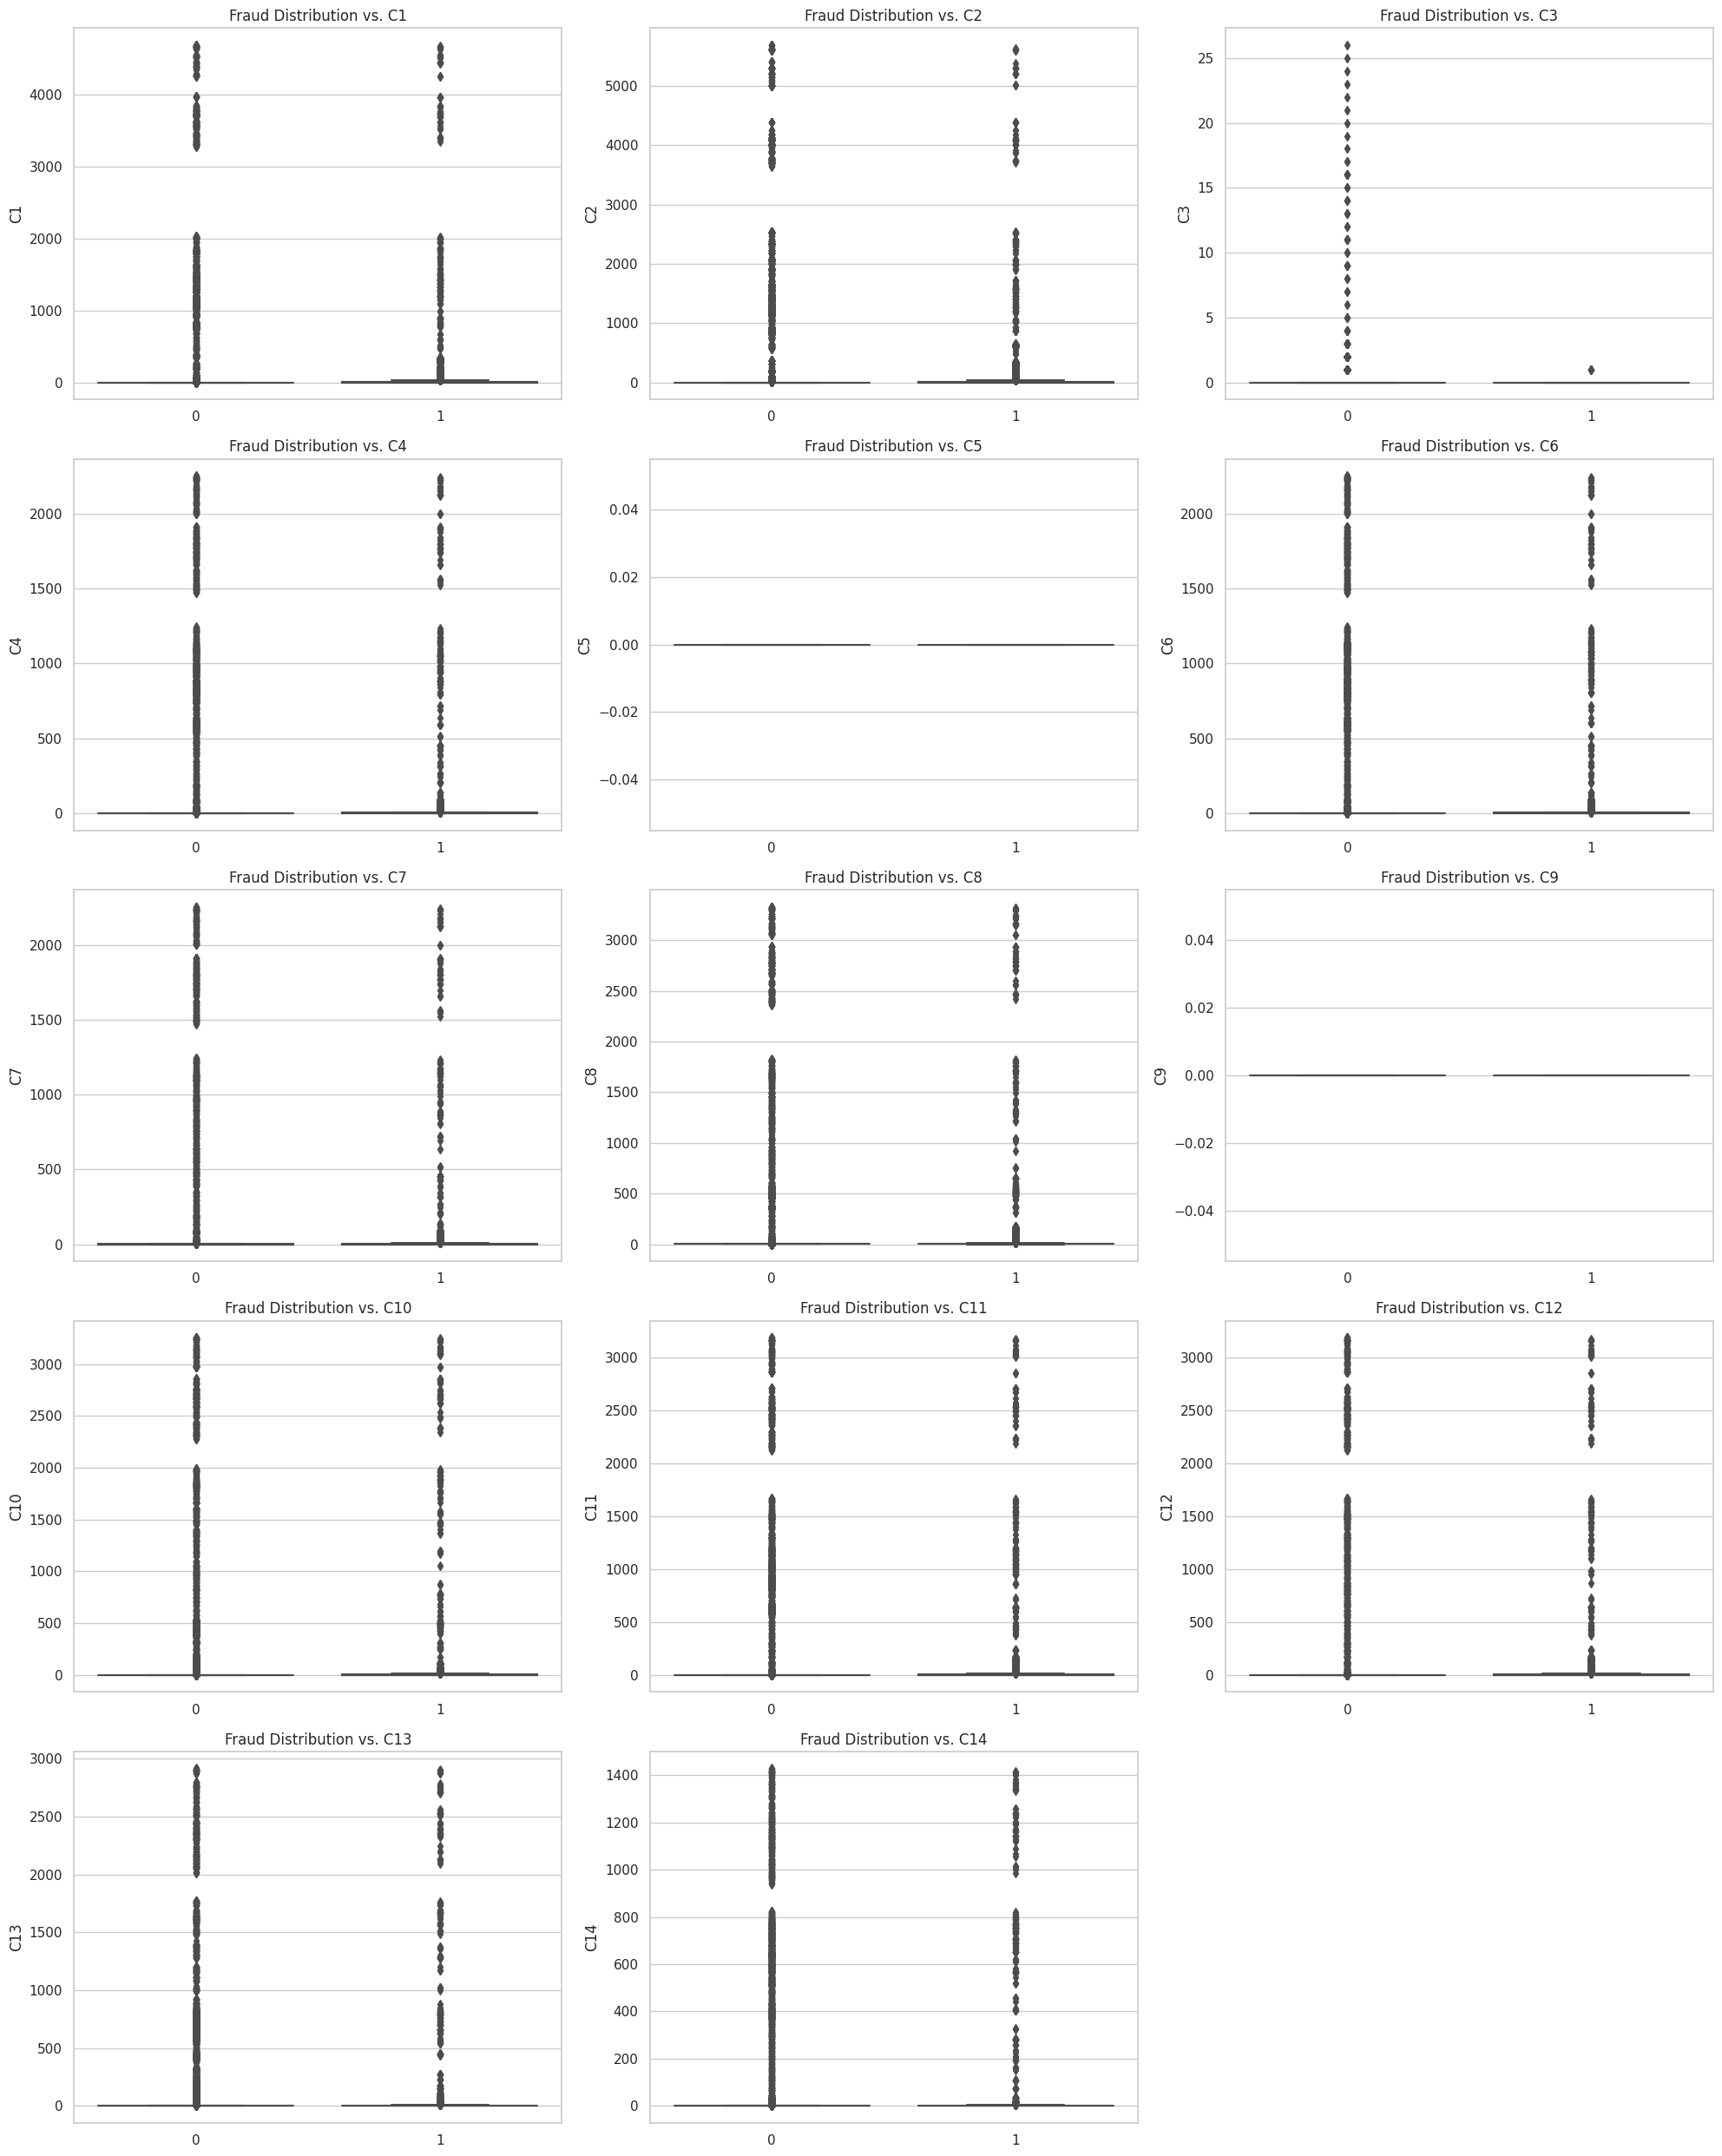

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

c_cols = [f'C{i}' for i in range(1, 15)]

plt.figure(figsize=(20, 25))
for i, col in enumerate(c_cols, 1):
    plt.subplot(5, 3, i)
    sns.boxplot(data=train_full, x='isFraud', y=col)
    plt.title(f"Fraud Distribution vs. {col}")
    plt.xlabel('')
    plt.ylabel(col)

plt.tight_layout()
plt.show()


In [53]:
train_full = train_full.rename(columns={
    'C1': 'recent_txn_count',
    'C2': 'card_usage_frequency',
    'C3': 'shared_device_count',
    'C4': 'billing_address_usage',
    'C5': 'shipping_address_usage',
    'C6': 'device_browser_combo_count',
    'C7': 'transaction_type_count',
    'C8': 'device_usage_frequency',
    'C9': 'inactive_device_count',
    'C10': 'merchant_category_count',
    'C11': 'location_terminal_count',
    'C12': 'rolling_txn_count_short_term',
    'C13': 'rolling_txn_count_mid_term',
    'C14': 'rolling_txn_count_long_term'
})

In [54]:
print(train_full.columns.tolist())

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card_id', 'issuer_bank_code', 'card3', 'card_network', 'card_bin', 'card_type', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'recent_txn_count', 'card_usage_frequency', 'shared_device_count', 'billing_address_usage', 'shipping_address_usage', 'device_browser_combo_count', 'transaction_type_count', 'device_usage_frequency', 'inactive_device_count', 'merchant_category_count', 'location_terminal_count', 'rolling_txn_count_short_term', 'rolling_txn_count_mid_term', 'rolling_txn_count_long_term', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', '_seq_day', '_seq_week', '_Date', '_ymd', '_year_month', '_weekday', '_hour', '_day', '_weekday_hour', '_amount_qcut10', 'id_30', 'id_31', 'DeviceType', 'DeviceInfo']


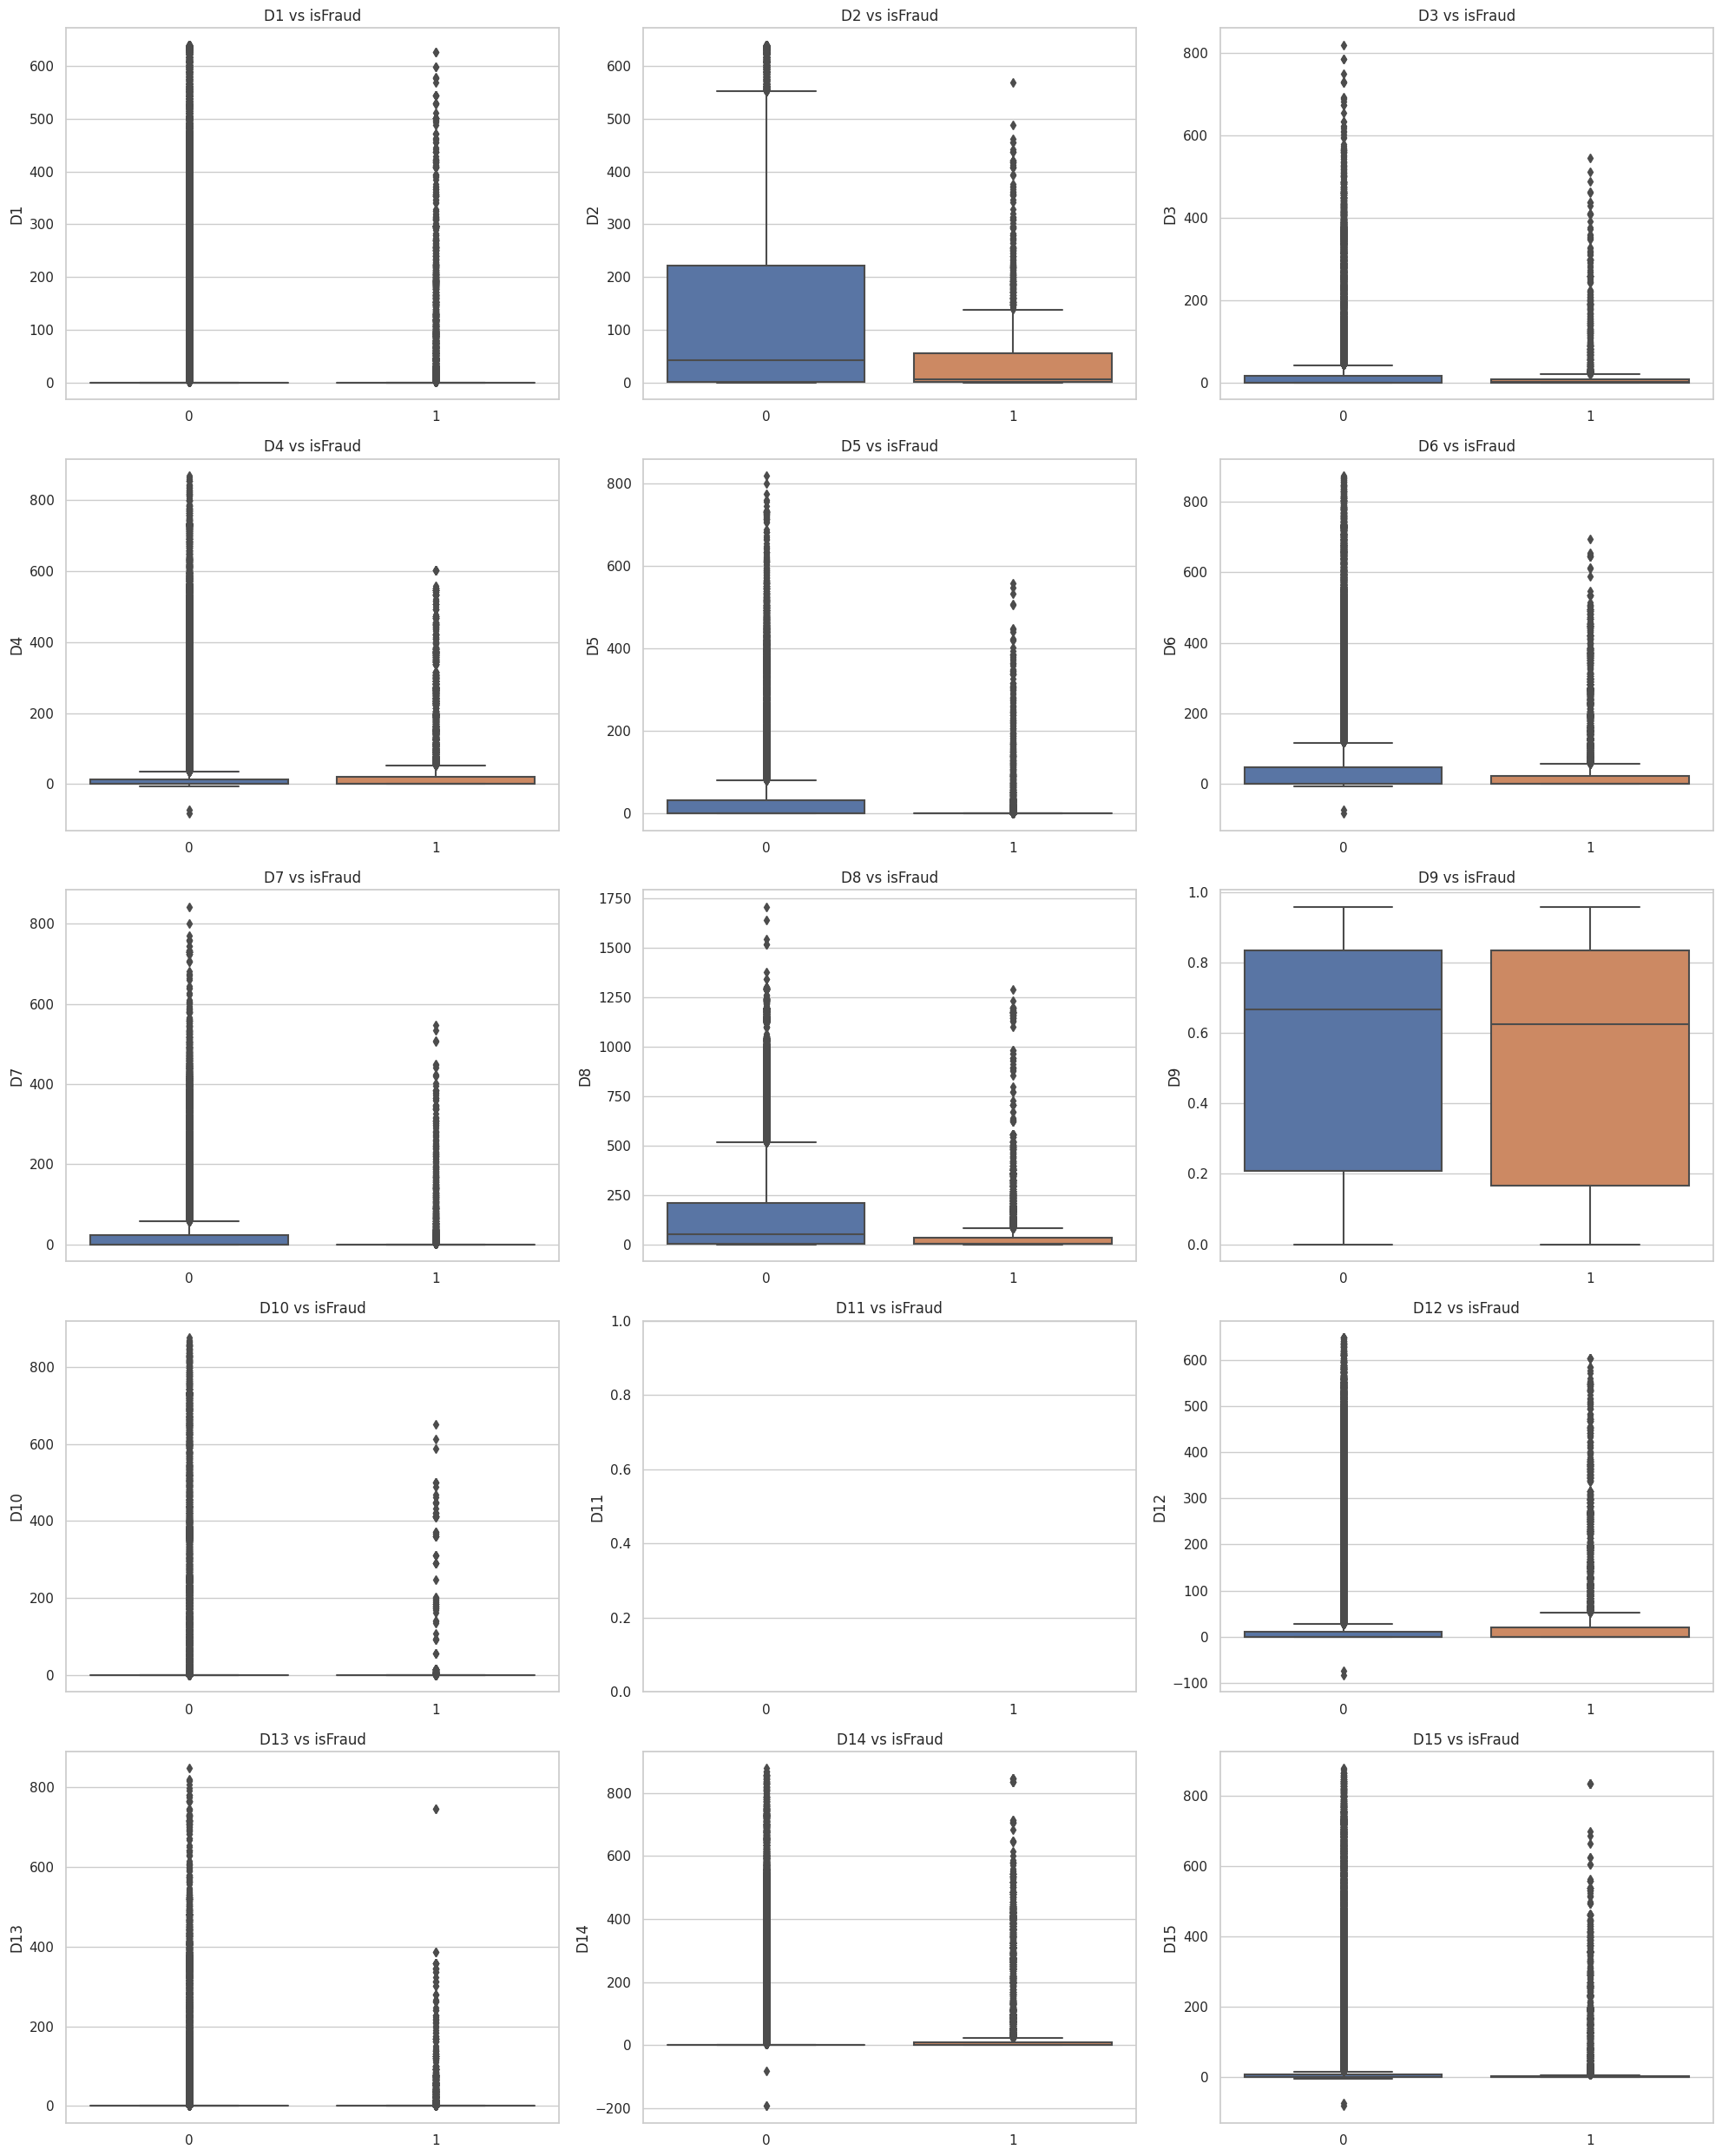

In [55]:
d_cols = [col for col in train_full.columns if col.startswith('D')][:15]

plt.figure(figsize=(20, 25))

for i, col in enumerate(d_cols, 1):
    plt.subplot(5, 3, i)
    sns.boxplot(data=train_full, x='isFraud', y=col)
    plt.title(f"{col} vs isFraud")
    plt.xlabel('')
    plt.ylabel(col)

plt.tight_layout()
plt.show()


In [56]:
train_full = train_full.rename(columns={
    'D1': 'days_since_prev_txn',                        # Short-term transaction gap
    'D2': 'days_since_first_txn',                       # Time since first known txn
    'D3': 'device_session_txn_gap',                     # Session-related txn gap
    'D4': 'txn_gap_same_card',                          # Time delta with same card
    'D5': 'txn_gap_same_billing_addr',                  # Time delta with same billing address
    'D6': 'days_since_last_login',                      # Last login delta
    'D7': 'days_since_last_device_use',                 # Last device use delta
    'D8': 'txn_gap_same_state',                         # Time since transaction in same state
    'D9': 'address_reuse_duration',                     # Possibly reused address duration
    'D10': 'billing_shipping_time_diff',                # Days between billing and shipping
    'D11': 'days_since_card_registration',              # Card registration or first use
    'D12': 'rolling_txn_time_short_term',               # Time feature (short window)
    'D13': 'rolling_txn_time_mid_term',                 # Time feature (mid window)
    'D14': 'rolling_txn_time_long_term',                # Time feature (long window)
    'D15': 'rolling_txn_time_extended'                  # Very long-term user behavior
})

In [57]:
train_full.head().T

,0,1,2,3,4
TransactionID,2987004,2987008,2987010,2987011,2987016
isFraud,0,0,0,0,0
TransactionDT,86506,86535,86549,86555,86620
TransactionAmt,50.000,15.000,75.875,16.500,30.000
ProductCD,H,H,C,C,H
...,...,...,...,...,...
_amount_qcut10,"(49.0, 57.938]","(0.25, 25.953]","(68.75, 100.0]","(0.25, 25.953]","(25.953, 35.938]"
id_30,Android 7.0,iOS 11.1.2,NaN,NaN,Mac OS X 10_11_6
id_31,samsung browser 6.2,mobile safari 11.0,chrome 62.0,chrome 62.0,chrome 62.0
DeviceType,mobile,mobile,desktop,desktop,desktop


In [58]:
print(train_full.columns.tolist())

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card_id', 'issuer_bank_code', 'card3', 'card_network', 'card_bin', 'card_type', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'recent_txn_count', 'card_usage_frequency', 'shared_device_count', 'billing_address_usage', 'shipping_address_usage', 'device_browser_combo_count', 'transaction_type_count', 'device_usage_frequency', 'inactive_device_count', 'merchant_category_count', 'location_terminal_count', 'rolling_txn_count_short_term', 'rolling_txn_count_mid_term', 'rolling_txn_count_long_term', 'days_since_prev_txn', 'days_since_first_txn', 'device_session_txn_gap', 'txn_gap_same_card', 'txn_gap_same_billing_addr', 'days_since_last_login', 'days_since_last_device_use', 'txn_gap_same_state', 'address_reuse_duration', 'billing_shipping_time_diff', 'days_since_card_registration', 'rolling_txn_time_short_term', 'rolling_txn_time_mid_term', 'rolling_txn_time_long_term', 'rolling_txn_time_exte

In [59]:
train_full = train_full.rename(columns = {
    'id_30' : 'Operating_system',
    'id_31' : 'Browser_type'
})

**For the M Columns**

Skipping M1 due to insufficient data
Skipping M2 due to insufficient data
Skipping M3 due to insufficient data


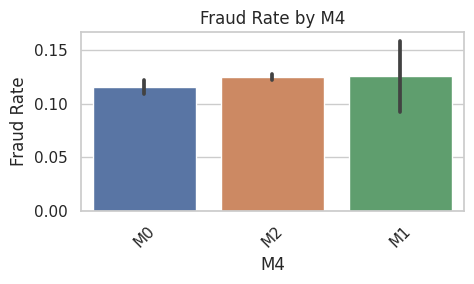

Skipping M5 due to insufficient data
Skipping M6 due to insufficient data
Skipping M7 due to insufficient data
Skipping M8 due to insufficient data
Skipping M9 due to insufficient data


In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in [f'M{i}' for i in range(1, 10)]:
    if train_full[col].nunique(dropna=True) < 2:
        print(f"Skipping {col} due to insufficient data")
        continue
    plt.figure(figsize=(5, 3))
    sns.barplot(data=train_full, x=col, y='isFraud', estimator='mean')
    plt.title(f'Fraud Rate by {col}')
    plt.ylabel('Fraud Rate')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [61]:
print(train_full['M4'])

0         NaN
1         NaN
2          M0
3          M0
4         NaN
         ... 
144228     M2
144229    NaN
144230     M2
144231    NaN
144232     M2
Name: M4, Length: 144233, dtype: object


In [62]:
train_full['M4'] = train_full['M4'].fillna('Unknown')

In [63]:
train_full.drop(columns = ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9', 'card3'], inplace = True)

In [64]:
train_full.rename(columns={'M4': 'match_status'}, inplace=True)

# **Feature Engineering Some Date Time columns**

**Time of Day Buckets (Morning, Afternoon, etc.)**

In [65]:
def get_time_bucket(hour):
    hour = int(hour)
    if 5 <= hour < 12: return 'morning'
    elif 12 <= hour < 17: return 'afternoon'
    elif 17 <= hour < 21: return 'evening'
    else: return 'night'

train_full['_hour_bucket'] = train_full['_hour'].astype(int).apply(get_time_bucket)

**Weekend vs Weekday**

In [66]:
train_full['_is_weekend'] = train_full['_weekday'].astype(int).isin([5, 6]).astype(int)

**Transaction Density by Hour**

In [67]:
hour_counts = train_full['_hour'].value_counts(normalize=True)
train_full['_hour_density'] = train_full['_hour'].map(hour_counts.to_dict())

In [68]:
train_full.drop(['_Date', '_ymd', '_year_month', '_day'], axis=1, inplace=True)

In [69]:
print(train_full.columns.tolist())

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card_id', 'issuer_bank_code', 'card_network', 'card_bin', 'card_type', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'recent_txn_count', 'card_usage_frequency', 'shared_device_count', 'billing_address_usage', 'shipping_address_usage', 'device_browser_combo_count', 'transaction_type_count', 'device_usage_frequency', 'inactive_device_count', 'merchant_category_count', 'location_terminal_count', 'rolling_txn_count_short_term', 'rolling_txn_count_mid_term', 'rolling_txn_count_long_term', 'days_since_prev_txn', 'days_since_first_txn', 'device_session_txn_gap', 'txn_gap_same_card', 'txn_gap_same_billing_addr', 'days_since_last_login', 'days_since_last_device_use', 'txn_gap_same_state', 'address_reuse_duration', 'billing_shipping_time_diff', 'days_since_card_registration', 'rolling_txn_time_short_term', 'rolling_txn_time_mid_term', 'rolling_txn_time_long_term', 'rolling_txn_time_extended', 'm

**Card details and other combining**

In [70]:
# 1. Combine email domain and addr1
train_full['_P_emaildomain__addr1'] = train_full['P_emaildomain'].fillna('unknown') + '__' + train_full['addr1'].astype(str)

# 2. Combine card_id and issuer_bank_code
train_full['_card_id__issuer'] = train_full['card_id'].astype(str) + '__' + train_full['issuer_bank_code'].astype(str)

# 3. Combine card_id and addr1
train_full['_card_id__addr1'] = train_full['card_id'].astype(str) + '__' + train_full['addr1'].astype(str)

# 4. Combine issuer_bank_code and addr1
train_full['_issuer__addr1'] = train_full['issuer_bank_code'].astype(str) + '__' + train_full['addr1'].astype(str)

# 5. Combine full card identifier with addr1
train_full['_cardid_issuer__addr1'] = train_full['_card_id__issuer'] + '__' + train_full['addr1'].astype(str)

In [71]:
cross_features = [
    '_P_emaildomain__addr1',
    '_card_id__issuer',
    '_card_id__addr1',
    '_issuer__addr1',
    '_cardid_issuer__addr1'
]

for col in cross_features:
    freq_map = train_full[col].value_counts().to_dict()
    train_full[col + '_freq'] = train_full[col].map(freq_map)

**Amount Features Engineered**

In [72]:
train_full['_amount_decimal'] = ((train_full['TransactionAmt'] - train_full['TransactionAmt'].astype(int)) * 1000).astype(int)
train_full['_amount_decimal_len'] = train_full['TransactionAmt'].apply(
    lambda x: len(re.sub('0+$', '', str(x)).split('.')[1]) if '.' in str(x) else 0
)
train_full['_amount_fraction'] = train_full['TransactionAmt'].apply(
    lambda x: float('0.' + re.sub('^[0-9]|\.|0+$', '', str(x))) if '.' in str(x) else 0.0
)

In [73]:
print(train_full.columns.tolist())

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card_id', 'issuer_bank_code', 'card_network', 'card_bin', 'card_type', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'recent_txn_count', 'card_usage_frequency', 'shared_device_count', 'billing_address_usage', 'shipping_address_usage', 'device_browser_combo_count', 'transaction_type_count', 'device_usage_frequency', 'inactive_device_count', 'merchant_category_count', 'location_terminal_count', 'rolling_txn_count_short_term', 'rolling_txn_count_mid_term', 'rolling_txn_count_long_term', 'days_since_prev_txn', 'days_since_first_txn', 'device_session_txn_gap', 'txn_gap_same_card', 'txn_gap_same_billing_addr', 'days_since_last_login', 'days_since_last_device_use', 'txn_gap_same_state', 'address_reuse_duration', 'billing_shipping_time_diff', 'days_since_card_registration', 'rolling_txn_time_short_term', 'rolling_txn_time_mid_term', 'rolling_txn_time_long_term', 'rolling_txn_time_extended', 'm

In [76]:
print(train_full['match_status'].unique())
print(train_full['match_status'].dtype)

['Unknown' 'M0' 'M2' 'M1']
object


In [77]:
train_full.drop(columns=['match_status'], inplace=True)

In [87]:
for col in train_full.columns:
    print(f"Column: {col}")
    print(f"Type: {train_full[col].dtype}")
    print(f"Sample values: {train_full[col].unique()[:5]}")
    print('-' * 40)

Column: TransactionID
Type: int32
Sample values: [2987004 2987008 2987010 2987011 2987016]
----------------------------------------
Column: isFraud
Type: int8
Sample values: [0 1]
----------------------------------------
Column: TransactionDT
Type: int32
Sample values: [86506 86535 86549 86555 86620]
----------------------------------------
Column: TransactionAmt
Type: float32
Sample values: [50.    15.    75.875 16.5   30.   ]
----------------------------------------
Column: ProductCD
Type: object
Sample values: ['H' 'C' 'S' 'R']
----------------------------------------
Column: card_id
Type: object
Sample values: ['4497' '2803' '16496' '4461' '1790']
----------------------------------------
Column: issuer_bank_code
Type: object
Sample values: ['514.0' '100.0' '352.0' '375.0' '555.0']
----------------------------------------
Column: card_network
Type: object
Sample values: ['mastercard' 'visa' 'american express' 'discover' 'nan']
----------------------------------------
Column: card_bi

**Ordinal Encoding**

In [74]:
numerical_cols = [
    'TransactionAmt', 'recent_txn_count', 'card_usage_frequency', 'shared_device_count',
    'billing_address_usage', 'shipping_address_usage', 'device_browser_combo_count',
    'transaction_type_count', 'device_usage_frequency', 'inactive_device_count',
    'merchant_category_count', 'location_terminal_count',
    'rolling_txn_count_short_term', 'rolling_txn_count_mid_term', 'rolling_txn_count_long_term',
    'days_since_prev_txn', 'days_since_first_txn', 'device_session_txn_gap', 'txn_gap_same_card',
    'txn_gap_same_billing_addr', 'days_since_last_login', 'days_since_last_device_use',
    'txn_gap_same_state', 'address_reuse_duration', 'billing_shipping_time_diff',
    'days_since_card_registration', 'rolling_txn_time_short_term', 'rolling_txn_time_mid_term',
    'rolling_txn_time_long_term', 'rolling_txn_time_extended',
    '_seq_day', '_seq_week', '_hour_density',
    '_P_emaildomain__addr1_freq', '_card_id__issuer_freq', '_card_id__addr1_freq',
    '_issuer__addr1_freq', '_cardid_issuer__addr1_freq',
    '_amount_decimal', '_amount_decimal_len', '_amount_fraction'
]

In [75]:
categorical_cols = [
    'ProductCD', 'card_id', 'issuer_bank_code', 'card_network', 'card_bin', 'card_type',
    'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain',
    '_weekday', '_hour', '_weekday_hour',
    'amount_qcut10', '_amount_qcut10',
    'Operating_system', 'Browser_type', 'DeviceType', 'DeviceInfo',
    '_hour_bucket', '_is_weekend', 'match_status',
    '_P_emaildomain__addr1', '_card_id__issuer', '_card_id__addr1',
    '_issuer__addr1', '_cardid_issuer__addr1'
]

In [89]:
label_encode_cols = [
    'ProductCD',
    'card_id',
    'issuer_bank_code',
    'card_network',
    'card_type',
    'addr1',
    'P_emaildomain',
    'R_emaildomain',
    '_weekday_hour',
    '_amount_qcut10',
    'Operating_system',
    'Browser_type',
    'DeviceType',
    'DeviceInfo',
    '_P_emaildomain__addr1',
    '_card_id__issuer',
    '_card_id__addr1',
    '_issuer__addr1',
    '_cardid_issuer__addr1',
    'P_emaildomain_1',
    'P_emaildomain_2',
    'P_emaildomain_3',
    'R_emaildomain_1',
    'R_emaildomain_2',
    'R_emaildomain_3'
]

In [90]:
one_hot_encode_cols = [
    '_hour_bucket',
    '_is_weekend'
]

In [78]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [79]:
pip install -U category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 89.0 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: category_encoders
    Found existing installation: category_encoders 2.7.0
    Uninstalling category_encoders-2.7.0:
      Successfully uninstalled category_encoders-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


**Ratio Features**

In [80]:
def generate_ratio_features(df, value_cols, group_cols, stat_ops):
    for val_col in value_cols:
        if val_col not in df.columns:
            continue
        for grp_col in group_cols:
            if grp_col not in df.columns:
                continue

            df[grp_col] = df[grp_col].astype(str)

            for stat in stat_ops:
                try:
                    stat_series = df.groupby(grp_col)[val_col].transform(stat)
                    feature_name = f'{val_col}_to_{stat}_{grp_col}'
                    df[feature_name] = df[val_col] / stat_series
                except Exception as e:
                    print(f"Skipped {val_col} grouped by {grp_col} ({stat}): {e}")
    return df


In [82]:
value_cols = [
    'TransactionAmt',
    'card_usage_frequency',
    'recent_txn_count',
    'rolling_txn_count_short_term',
    'amount_fraction'
]

group_cols = [
    'card_id',
    'issuer_bank_code',
    'card_network',
    'addr1',
    'P_emaildomain'
]

stat_ops = ['mean', 'std']

train_full = generate_ratio_features(train_full, value_cols, group_cols, stat_ops)

In [83]:
def safe_split_email_column(df, col_name):

    split_cols = df[col_name].astype(str).str.split('.', expand=True)

    for i in range(3 - split_cols.shape[1]):
        split_cols[split_cols.shape[1]] = 'None'

    split_cols.columns = [f'{col_name}_{i+1}' for i in range(3)]
    
    return split_cols

p_split_train = safe_split_email_column(train_full, 'P_emaildomain')
r_split_train = safe_split_email_column(train_full, 'R_emaildomain')

train_full = pd.concat([train_full, p_split_train, r_split_train], axis=1)

**Encoding**

In [91]:
from sklearn.preprocessing import LabelEncoder
import pickle

encoders = {}

for col in label_encode_cols:
    if col in train_full.columns:
        le = LabelEncoder()
        train_full[col] = train_full[col].astype(str)
        le.fit(train_full[col])
        train_full[col] = le.transform(train_full[col])
        encoders[col] = le

with open("label_encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)

**One-Hot Encode Low Cardinality Features**

In [92]:
import pandas as pd
import pickle

low_card_cols = ['_hour_bucket', '_is_weekend']

existing_low_card_cols = [col for col in low_card_cols if col in train_full.columns]

train_full_NoV = pd.get_dummies(train_full, columns=existing_low_card_cols, drop_first=True)

one_hot_columns = train_full.columns.tolist()

with open("one_hot_structure.pkl", "wb") as f:
    pickle.dump(one_hot_columns, f)

In [93]:
train_full.drop(columns = ['_seq_week', '_weekday', '_seq_day', '_hour'], inplace = True)

# Drop Useless Columns

In [94]:
many_null_cols = [col for col in train_full.columns if train_full[col].isnull().mean() > 0.9]

In [95]:
big_top_value_cols = [
    col for col in train_full.columns 
    if train_full[col].value_counts(dropna=False, normalize=True).values[0] > 0.9
]

In [96]:
one_value_cols = [col for col in train_full_NoV.columns if train_full_NoV[col].nunique(dropna=False) <= 1]

In [99]:
cols_to_drop = set(
    many_null_cols + 
    big_top_value_cols + 
    one_value_cols
)

In [100]:
cols_to_drop.discard('isFraud')
cols_to_drop = list(cols_to_drop)

In [101]:
train_full.drop(columns=[col for col in cols_to_drop if col in train_full_NoV.columns], inplace=True)

print(f"Dropped {len(cols_to_drop)} uninformative columns (where applicable).")

Dropped 7 uninformative columns (where applicable).


# **Model**

In [102]:
X = train_full_NoV.drop(['isFraud'], axis=1)
y = train_full_NoV['isFraud']

In [103]:
print(X.columns.tolist())

['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card_id', 'issuer_bank_code', 'card_network', 'card_bin', 'card_type', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'recent_txn_count', 'card_usage_frequency', 'shared_device_count', 'billing_address_usage', 'shipping_address_usage', 'device_browser_combo_count', 'transaction_type_count', 'device_usage_frequency', 'inactive_device_count', 'merchant_category_count', 'location_terminal_count', 'rolling_txn_count_short_term', 'rolling_txn_count_mid_term', 'rolling_txn_count_long_term', 'days_since_prev_txn', 'days_since_first_txn', 'device_session_txn_gap', 'txn_gap_same_card', 'txn_gap_same_billing_addr', 'days_since_last_login', 'days_since_last_device_use', 'txn_gap_same_state', 'address_reuse_duration', 'billing_shipping_time_diff', 'days_since_card_registration', 'rolling_txn_time_short_term', 'rolling_txn_time_mid_term', 'rolling_txn_time_long_term', 'rolling_txn_time_extended', '_seq_day', '

In [104]:
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import numpy as np

def train_model_classification(X, y, params, folds, eval_metric='auc',
                               early_stopping_rounds=100, n_estimators=5000, n_jobs=-1):
    
    oof = np.zeros(len(X))
    scores = []
    models = []
    
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started...')
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs=n_jobs)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  eval_metric=eval_metric,
                  callbacks=[lgb.early_stopping(early_stopping_rounds, verbose=True)])

        y_pred_valid = model.predict_proba(X_valid)[:, 1]
        oof[valid_idx] = y_pred_valid
        score = roc_auc_score(y_valid, y_pred_valid)
        scores.append(score)
        print(f'Fold {fold_n + 1} AUC: {score:.5f}')
        
        models.append(model)
    
    print(f'CV mean AUC: {np.mean(scores):.5f}')

    return {
        'oof': oof,
        'scores': scores,
        'models': models,
    }


In [105]:
from sklearn.model_selection import KFold
import lightgbm as lgb
import gc

n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

params = {
    'num_leaves': 256,
    'min_child_samples': 79,
    'objective': 'binary',
    'max_depth': 13,
    'learning_rate': 0.03,
    'boosting_type': 'gbdt',
    'subsample_freq': 3,
    'subsample': 0.9,
    'bagging_seed': 11,
    'metric': 'auc',
    'verbosity': -1,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'colsample_bytree': 0.9,
}

result_dict_lgb = train_model_classification(
    X=X,
    y=y,
    params=params,
    folds=folds,
    eval_metric='auc',
    early_stopping_rounds=200,
    n_estimators=5000,
    n_jobs=-1
)

gc.collect()

Fold 1 started...
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[926]	training's auc: 1	valid_1's auc: 0.980648
Fold 1 AUC: 0.98065
Fold 2 started...
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[744]	training's auc: 1	valid_1's auc: 0.978862
Fold 2 AUC: 0.97886
Fold 3 started...
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[824]	training's auc: 1	valid_1's auc: 0.980503
Fold 3 AUC: 0.98050
Fold 4 started...
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1024]	training's auc: 1	valid_1's auc: 0.982045
Fold 4 AUC: 0.98205
Fold 5 started...
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[842]	training's auc: 1	valid_1's auc: 0.980395
Fold 5 AUC: 0.98040
CV mean AUC: 0.98049


478

In [106]:
print(result_dict_lgb.keys())
models = result_dict_lgb['models']

dict_keys(['oof', 'scores', 'models'])


In [107]:
oof = np.zeros(len(X))
from sklearn.metrics import accuracy_score
threshold = 0.5

y_pred_binary = (oof >= threshold).astype(int)

accuracy = accuracy_score(y, y_pred_binary)

print(f"Validation Accuracy (threshold={threshold}): {accuracy:.4f}")

Validation Accuracy (threshold=0.5): 0.9215


In [108]:
import pickle
with open("model.pkl", "wb") as f:
    pickle.dump(models, f)